### Домашнее задание  
Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:  
    1 - бустинг,  
    2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)  
    
Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)  

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.  

(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3 

(опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import itertools
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [3]:
def make_pipeline_for_lr(ohe_columns,all_columns,estimator = LogisticRegression(),type_ofprocessing=1):
    final_transformers = list()

   
    for col in all_columns:
        if col in ohe_columns:
            cat_transformer = Pipeline([
                        ('selector', FeatureSelector(column=col)),
                        ('ohe', OHEEncoder(key=col))
                    ])
            final_transformers.append((col, cat_transformer))
        else: 
            if type_ofprocessing ==1:
                    cont_transformer = Pipeline([
                                ('selector', NumberSelector(key=col)),
                                ('standart',StandardScaler())
                            ])
                    final_transformers.append((col, cont_transformer))
            else:
                    cont_transformer = Pipeline([
                                ('selector', NumberSelector(key=col)),
                                ('standart',MinMaxScaler())
                            ])
                    final_transformers.append((col, cont_transformer))
           
    feats = FeatureUnion(final_transformers)   
    pipeline = Pipeline([
    ('features',feats),
    ('classifier', estimator),
        ])
    return pipeline

In [51]:
def objective_LGBMClassifier(trial):
    param = {
        "verbosity": -1,

        "reg_alpha": trial.suggest_float("lambda_l1", 1e-8, 50.0, log=True),
        "reg_lambda": trial.suggest_float("lambda_l2", 1e-8, 50.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "n_estimators": trial.suggest_int("n_estimators", 25, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
    }

    gbm = LGBMClassifier(**param)
    res = make_cross_validation(df_1.drop('target',1),
                          df_1['target'],
                          gbm,
                          roc_auc_score,
                          cv_strategy,print_is=None)[1]

    return res



def objective_XGBClassifier(trial):
    param = {
        "verbosity": 0,
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 50.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 50.0, log=True),
        "gamma": trial.suggest_int("gamma", 0, 50),
        "n_estimators": trial.suggest_int("n_estimators", 25, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "subsample": trial.suggest_float("subsample", 0.01, 1),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 4),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1),
        
    }

    gbm = XGBClassifier(**param)
    res = make_cross_validation(df_1.drop('target',1),
                          df_1['target'],
                          gbm,
                          roc_auc_score,
                          cv_strategy,print_is=None)[1]
   
    
    
    return res


def objective_CatBoostClassifier(trial):
    param = {
        'verbose':False,
        'early_stopping_rounds': 90,
        "n_estimators": trial.suggest_int("n_estimators", 25, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "max_bin": trial.suggest_int("max_bin", 5,50),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 50)
 
    }

    gbm = CatBoostClassifier(**param)
    res = make_cross_validation(df_1.drop('target',1),
                          df_1['target'],
                          gbm,
                          roc_auc_score,
                          cv_strategy,print_is=None)[1]
  
    
    return res

In [5]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,print_is = True):
   
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train) 

        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if print_is:
            print(msg)
            print("="*69)
        estimators.append(estimator)
    oof_score = metric(y, oof_predictions)
    if print_is:
        print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
        print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
        print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [6]:
def test_estimators(train,target,estimators,cv_strategy,metric,print_is = True):
    res_base ={}
    for n,e in estimators:
        if print_is:
            print()
            print(f'#########################################   {n}   ###################################################')
            print()
        res_base[n] = make_cross_validation(train,
                          target,
                          e,
                          metric,
                          cv_strategy,print_is = print_is)[1]
    return    res_base     

In [7]:
def get_nan_feature_stat(train,feature,target):
    data = train.copy()
    print(f'Количество пропусков  - {len(data[data[feature].isna()][feature])}'  +'\n','-'*60)    
    print('Значения показателя и их частоты:')   
    print(data[feature].value_counts(),'\n','-'*60)
    print('Статистики показателя:')   
    print(data[feature].describe(),'\n','-'*60)
    print('Доля целевой переменной в пропущенных значениях:')   
    print(data[data[feature].isna()][target].value_counts(normalize=True),'\n','-'*60)
    print('Доля целевой переменной в не пропущенных значениях:')   
    print(data[~data[feature].isna()][target].value_counts(normalize=True),'\n','-'*60)
    print('Общая доля целевой переменной:')   
    print(data[target].value_counts(normalize=True),'\n','-'*60)   
    
def barplot_for_nan_proportion_of_features_by_target(train,feature,target):
    a=train[train[feature].isna()][target].value_counts()[1]
    b=train[train[feature].isna()][target].value_counts()[0]
    c=train[~train[feature].isna()][target].value_counts()[1]
    d=train[~train[feature].isna()][target].value_counts()[0]
    plt.bar('nan',a+b)
    plt.bar('nan',a)
    plt.bar('is data',c+d)
    plt.bar('is data',c)
    plt.title('Распределение целевой переменной в пропущенных значениях и не пропущенных')
    
    
def test_train_hist(train,test,feature):
    train[feature].hist(bins = 50)
    test[feature].hist(bins = 50)
    plt.title('гистограмма теста и трейна')
    
def distplot_test_train(train,test,feature):
    sns.distplot(train[feature],bins=50)
    sns.distplot(test[feature],bins=50)
    plt.title('распределение теста и трейна')
    
def barplot_positiv_target(train,feature,target):
    plt.figure(figsize=(25, 10))
    data = train.groupby(feature)[target].sum()
    sns.barplot(
        x=data.index,
        y=data.values
    )
    plt.title('Количество положительногот таргета на разных значениях признака')
    
def kdeplot_feature_target(train,feature,target):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(train[train[target]==0][feature], shade=True, label='0', color='g')
    sns.kdeplot(train[train[target]==1][feature], shade=True, label='1', color='r')

    plt.xlabel(feature)
    plt.title(f'{feature} grouped by target variable')
    
def kolmogorov_smirnov_test(train,test,feature):
    statistic, pvalue = ks_2samp( train[feature], test[feature])
    return statistic, pvalue

def u_test(train,feature,target):
    stat, p = mannwhitneyu(train[train[target]==0][feature],\
    train[train[target]==1][feature])
    return stat, p
    
    
def barplot_feature_corr(train,feature):
    data = x=train.corr()[feature].sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=data.values[1:], y=data.index[1:])
    plt.title(f'Correlation vs {feature}')
    
def barplot_feature_corr_kend(train,feature):
    data = train.corr(method='kendall')[feature].sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=data.values[1:], y=data.index[1:])
    plt.title(f'Correlation kendall vs {feature}')
    
def non_linear_link_for_nan(model,feature,columns):
    a=pd.Series(model.feature_importances_,index=columns)
    a=a.sort_values(ascending=False)
    print(a)
    print('='*60)
    fig = plt.figure(figsize=(20,10))
    sns.barplot(x=a.index,y=a.values)
    plt.show()
    print('='*60)
    print(f'6 наиболее значимых признаков {a.index[:6]}')
    print('='*60)
    features = a.index[:6]
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    for num, feat in enumerate(features):
        sns.regplot(
            x=feature,
            y=feat,
            data=train,
            ax=axes[num%3, num//3],
            scatter=True,
            fit_reg=True
        )
        
def matching_after_changes(old,new,feature):
    new[feature].hist(bins = 50)
    old[feature].hist(bins = 50)
    plt.show()
    sns.distplot(new[feature],bins=50)
    sns.distplot(old[feature],bins=50)
    plt.show()
    
def best_distribution_value(train,target,feature):
    positiv = train[train[feature].isna()][target].value_counts(normalize=True)[1]
    best_positiv = 0
    best_delta = 100000
    for i in train[feature]:
        if i:
            try:
                delta =  np.abs(train[train[feature]==i][target].value_counts(normalize=True)[1]-positiv)
            except:
                continue
            if delta<best_delta:
                best_delta = delta
                best_positiv = i
        else:
            continue       
    return best_positiv,positiv,best_delta      
        
def barplot_positiv_target_proportion(train,feature,target):
    plt.figure(figsize=(25, 10))
    data = train.groupby(feature)[target].mean()
    sns.barplot(
        x=data.index,
        y=data.values
    )
    plt.title('Доля положительногот таргета на разных значениях признака')   

In [8]:
def cat_feature_analysis(train,feature,target):
    print('Основные статистические показатели')
    print('='*70)
    get_nan_feature_stat(train,feature,target)
    plt.scatter(train[feature],train[target])
    plt.title(f'скатер  плот для признака {feature} с таргетом')
    plt.show()
#     test_train_hist(train,test,feature)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    ax[0].hist(train.sort_values(feature)[feature],label='train',color = 'red')
#     ax[1].hist(test.sort_values(feature)[feature],label='test')
    fig.legend("Значения признаков на тесте и трейне")  
    barplot_positiv_target_proportion(train,feature,target)
    plt.show()
    barplot_positiv_target(train,feature,target)
    plt.show()
#     print (f'Значения теста Колмогорова-Смирнова {kolmogorov_smirnov_test(train,test,feature)}')
    print('='*70)
    print('Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни')
    print (f'Значения U - теста  {u_test(train,feature,target)}')
    print('='*70)
    print('Построим доверительные интервалы для средних значений каждой из двух групп и сравним их')
    plt.figure(figsize=(10, 8))
    sns.pointplot(x=target, y=feature, data=train[[feature,target]], capsize=.1)
    plt.title(f'Confidence intervals (95 %) for {feature}')
    plt.show()
    print('='*70)
    
    
def feature_analysis(train,feature,target):
    print('Основные статистические показатели')
    print('='*70)
    get_nan_feature_stat(train,feature,target)
    sns.boxplot(train[feature])
    plt.title(f'Бокс плот для признака {feature}')
    plt.show()
    plt.scatter(train[feature],train[target])
    plt.title(f'скатер  плот для признака {feature} с таргетом')
    plt.show()
    plt.show()

#     test_train_hist(train,test,feature)
    plt.show()
#     distplot_test_train(train,test,feature)
    plt.show()
    barplot_positiv_target_proportion(train,feature,target)
    plt.show()
    barplot_positiv_target(train,feature,target)
    plt.show()
    kdeplot_feature_target(train,feature,target)
    plt.show()
#     print (f'Значения теста Колмогорова-Смирнова {kolmogorov_smirnov_test(train,test,feature)}')
    print('='*70)
    print('Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни')
    print (f'Значения U - теста  {u_test(train,feature,target)}')
    print('='*70)
    print('Построим доверительные интервалы для средних значений каждой из двух групп и сравним их')
    plt.figure(figsize=(10, 8))
    sns.pointplot(x=target, y=feature, data=train[[feature,target]], capsize=.1)
    plt.title(f'Confidence intervals (95 %) for {feature}')
    plt.show()
    print('='*70)
    print('Посмотрим на корреляцию данного признака к другим')
    print(train.corr()[feature].sort_values(ascending=False)[1:])
    print('='*70)
    barplot_feature_corr(train,feature)
    plt.show()
    print('Коэф. Кендала')
    print(train.corr(method='kendall')[feature].sort_values(ascending=False)[1:])
    print('='*70)
    barplot_feature_corr_kend(train,feature)
    plt.show()

In [9]:
def get_metrics(probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix],
                                                                            roc_auc_score(y_test, probs)))
    return thresholds[ix]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
df = pd.read_csv("churn_data.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [11]:
df_work  = df.drop(['RowNumber','CustomerId','Surname'],1) 
df_work.rename(columns={'Exited':'target'},inplace=True) 

In [12]:
df_work

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [13]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  target           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [14]:
df_work.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [15]:
df_work['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [16]:
df_work['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

### Посмотрим результаты работы алгоритмов без каких либо измнений в данных (кроме LR)

In [17]:
for_ohe_columns = ['Geography','Gender']


In [18]:
df_1= df_work.copy()
df_1['Geography'] = df['Geography'].map(df['Geography'].value_counts())/df_work['Geography'].count()
df_1['Gender'] = df['Gender'].map(df['Gender'].value_counts())/df_work['Gender'].count()


In [19]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=100)

In [20]:
pipeline_lr = make_pipeline_for_lr(for_ohe_columns,df_1.drop('target',1).columns.to_list())

In [21]:
estimators_base = [('lr',pipeline_lr),
              ('rf',RandomForestClassifier()),
              ('lgb',LGBMClassifier()),
              ('xgb',XGBClassifier()),
              ('cb',CatBoostClassifier(verbose = False)) ]

In [22]:
res_base = test_estimators(df_1.drop('target',1),df_1['target'],estimators_base,cv_strategy,roc_auc_score)


#########################################   lr   ###################################################

Fold: 1, train-observations = 8000, valid-observations = 2000
train-score = 0.77, valid-score = 0.7565
Fold: 2, train-observations = 8000, valid-observations = 2000
train-score = 0.76, valid-score = 0.7956
Fold: 3, train-observations = 8000, valid-observations = 2000
train-score = 0.769, valid-score = 0.7613
Fold: 4, train-observations = 8000, valid-observations = 2000
train-score = 0.7724, valid-score = 0.7455
Fold: 5, train-observations = 8000, valid-observations = 2000
train-score = 0.767, valid-score = 0.767
CV-results train: 0.7677 +/- 0.004
CV-results valid: 0.7652 +/- 0.017
OOF-score = 0.7649

#########################################   rf   ###################################################

Fold: 1, train-observations = 8000, valid-observations = 2000
train-score = 1.0, valid-score = 0.8394
Fold: 2, train-observations = 8000, valid-observations = 2000
train-score = 1.0, vali

##### Результаты тестирования без подбора гиперпапаметров

In [23]:
a=list(res_base.items())
a.sort(key = lambda x:x[1],reverse=True)
for i,j in a:
    print(f'в моделе {i}, метрика roc_auc OOF-score = {j}')

в моделе cb, метрика roc_auc OOF-score = 0.8637137482506074
в моделе lgb, метрика roc_auc OOF-score = 0.8593407987642404
в моделе rf, метрика roc_auc OOF-score = 0.8490464705103027
в моделе xgb, метрика roc_auc OOF-score = 0.8417467544881576
в моделе lr, метрика roc_auc OOF-score = 0.7649068645973145


### Посмотрим как влияет изменение параметров на качетво

#### Линейная регрессия

In [24]:
param_grid_lr = {'classifier__penalty':['l1', 'l2'],
                 'classifier__C': [0,0.001,0.003,0.004,0.005,0.008,0.01,0.05,0.1,0.5,1,5,10,15,20,30,40,50,75,100],
                 'classifier__solver':['lbfgs','liblinear'],}

In [25]:

clf_lr = GridSearchCV(pipeline_lr, param_grid_lr,\
                   scoring='roc_auc',n_jobs = -1,cv =cv_strategy)

In [26]:
a=clf_lr.fit(df_work.drop('target',1), df_work['target'])
print(a.best_score_,a.best_params_)

0.7660318566567171 {'classifier__C': 0.003, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [27]:
pipeline_lr = make_pipeline_for_lr(for_ohe_columns,df_work.drop('target',1).columns.to_list(),estimator=LogisticRegression(\
                           penalty = 'l2', solver='liblinear',C =0.003))

#### RandomForestClassifier

In [28]:

param_grid_rf = {'n_estimators':[250,270,290,300,350,400,450,500],
                 'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12],
                 'min_samples_leaf':[3,4,5,6,7,8,9,10,11,12,13,14],
    
}

RandomForestClassifier на GridSearchCV

In [29]:

clf_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf,\
                   scoring='roc_auc',n_jobs = -1,cv =cv_strategy)

In [30]:
%%time
b=clf_rf.fit(df_1.drop('target',1), df_1['target'])
print(b.best_score_,b.best_params_)

0.8611741624058581 {'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 270}
Wall time: 15min 43s


RandomForestClassifier на RandomizedSearchCV

In [31]:
rsp_rf = RandomizedSearchCV(RandomForestClassifier(),param_grid_rf,scoring='roc_auc',n_jobs = -1,cv =cv_strategy,n_iter = 100)

In [32]:
%%time
z=rsp_rf.fit(df_1.drop('target',1), df_1['target'])
print(z.best_score_,z.best_params_)

0.8609284133787721 {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 9}
Wall time: 1min 34s


Результаты почти одинаковые , время работы сильно отличается

#### LGBMClassifier

In [33]:
params_lgb = {
    'num_leaves':[5,10,15,20,25,30,35,40,50,70,100],
    'max_depth':[-1,2,4,6,8,10,12] ,
    "learning_rate":[0.01,0.05,0.1,0.2,0.3,0.5] ,
    "n_estimators":[50,100,150,200,300,400,500,1000],
    'min_child_samples':[5,10,15,20,25,30,35,40,45,50],
    'reg_alpha': [0,0.5,1,1.5,2,3,4,5,10,20,30,40,50],
    'reg_lambda':[0,0.5,1,2,5,7,10,15,20,30,40,50],

}

На GridSearchCV  все это авполнитть не реально... Нужно несколько суток

In [34]:
# clf_lgb = GridSearchCV(LGBMClassifier(),params_lgb,\
#                    scoring='roc_auc',n_jobs = -1,cv =cv_strategy)

In [35]:
# %%time
# c=clf_lgb.fit(df_1.drop('target',1), df_1['target'])
# print(c.best_score_,c.best_params_)

LGBMClassifier на RandomizedSearchCV 

In [40]:
rsp_lgb = RandomizedSearchCV(LGBMClassifier(),params_lgb,scoring='roc_auc',n_jobs = -1,cv =cv_strategy,n_iter = 1000)

In [41]:
%%time
y=rsp_lgb.fit(df_1.drop('target',1), df_1['target'])
print(y.best_score_,y.best_params_)

0.8662864657693611 {'reg_lambda': 0.5, 'reg_alpha': 0, 'num_leaves': 15, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 8, 'learning_rate': 0.05}
Wall time: 2min 3s


LGBMClassifier на optuna

In [44]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective_LGBMClassifier, n_trials=1000)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 1000
Best trial:
  Value: 0.8667638453769154
  Params: 
    lambda_l1: 3.048769590195501e-05
    lambda_l2: 0.977640442683296
    num_leaves: 13
    min_child_samples: 22
    n_estimators: 802
    learning_rate: 0.01000774839888891
    max_depth: 12
Wall time: 29min 57s


Хваленный optuna потратил времени больше, результат хуже RandomizedSearchCV

#### XGBClassifier

In [45]:
params_xgb = {
    "n_estimators":[50,100,150,200,300,400,500,1000],
    'max_depth':[-1,2,4,6,8,10,12] ,
    "learning_rate":[0.01,0.05,0.1,0.2,0.3,0.5] ,
    'gamma':[0,0.5,1,1.5,2,3,4,5,10,20,30,40,50],
    'reg_alpha': [0,0.5,1,1.5,2,3,4,5,10,20,30,40,50],
    'reg_lambda':[0,0.5,1,2,5,7,10,15,20,30,40,50], 
    'colsample_bytree' :[0.01,0.5,1,1.5,2],
    'min_child_weight' :[0.01,0.5,1,1.5,2],
    'subsample':[0.01,0.5,1,1.5,2],
    
}

На GridSearchCV все это авполнитть не реально... Нужно несколько суток

In [ ]:
# clf_xgb = GridSearchCV(XGBClassifier(),params_xgb,\
#                    scoring='roc_auc',n_jobs = -1,cv =cv_strategy)

In [ ]:
# %%time
# d=clf_xgb.fit(df_1.drop('target',1), df_1['target'])
# print(d.best_score_,d.best_params_)

XGBClassifier на RandomizedSearchCV

In [46]:
rsp_xgb = RandomizedSearchCV(XGBClassifier(),params_xgb,scoring='roc_auc',n_jobs = -1,cv =cv_strategy,n_iter = 1000)

In [47]:
%%time
x=rsp_xgb.fit(df_1.drop('target',1), df_1['target'])
print(x.best_score_,x.best_params_)

0.8663965692458782 {'subsample': 1, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1.5, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 10, 'colsample_bytree': 0.5}
Wall time: 2min 15s


XGBClassifier на optuna

In [48]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective_XGBClassifier, n_trials=500)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 500
Best trial:
  Value: 0.8685591207888276
  Params: 
    reg_alpha: 2.735249617499041e-08
    reg_lambda: 1.2041062157071088e-05
    gamma: 9
    n_estimators: 870
    learning_rate: 0.01139470666674852
    max_depth: 8
    subsample: 0.9198913247558065
    min_child_weight: 2.2399908807334286
    colsample_bytree: 0.6452059324741106
Wall time: 1h 16min 40s


Время в 4 раза больше, рещультат немного лучше

#### CatBoostClassifier

In [49]:
params_cb={
     "n_estimators": [100,200,300,400,500,600,700,800],
     'learning_rate':[0.01,0.03,0.05,0.1,0.5,1],
     "max_depth": [2,4,6,8,10,12],
     "max_bin": [10,20,30,40],
     "l2_leaf_reg": [0,5,10,20,30, 40,50],

}

На GridSearchCV все это авполнитть не реально... Нужно несколько суток

In [ ]:
# clf_cb = GridSearchCV(CatBoostClassifier(early_stopping_rounds= 90,verbose= False),params_cb,\
#                    scoring='roc_auc',n_jobs = -1,cv =cv_strategy)

In [ ]:
# %%time
# e=clf_cb.fit(df_1.drop('target',1), df_1['target'])
# print(e.best_score_,e.best_params_)

CatBoostClassifier на RandomizedSearchCV

In [50]:
rsp_cb = RandomizedSearchCV(CatBoostClassifier(early_stopping_rounds= 90,verbose= False),params_cb,scoring='roc_auc',n_jobs = -1,cv =cv_strategy,n_iter = 200)

In [53]:
%%time
t=rsp_cb.fit(df_1.drop('target',1), df_1['target'])
print(t.best_score_,t.best_params_)

0.8687671941005896 {'n_estimators': 200, 'max_depth': 6, 'max_bin': 40, 'learning_rate': 0.03, 'l2_leaf_reg': 10}
Wall time: 25min 15s


CatBoostClassifier на optuna

In [52]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective_CatBoostClassifier, n_trials=500)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 500
Best trial:
  Value: 0.8694725254523082
  Params: 
    n_estimators: 878
    learning_rate: 0.010175075470128993
    max_depth: 6
    max_bin: 46
    l2_leaf_reg: 5.067068281469649
Wall time: 1h 40min 28s


##### Запишем результаты после настройки гипер параметров

In [54]:
pipeline_lr = make_pipeline_for_lr(for_ohe_columns,df_1.drop('target',1).columns.to_list(),estimator=LogisticRegression(
                           penalty = 'l2', solver='liblinear',C =0.003))

In [55]:
estimators = [('lr',pipeline_lr),
              ('rf',RandomForestClassifier()),
              ('lgb',LGBMClassifier()),
              ('xgb',XGBClassifier()),
              ('cb',CatBoostClassifier(verbose = False)) ]

In [56]:
estimators = [('lr',pipeline_lr),
 ('rf',RandomForestClassifier(**{'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 300})),
 ('lgb',LGBMClassifier(**{'reg_lambda': 1,
                          'reg_alpha': 1, 'num_leaves': 20, 
                          'n_estimators': 400, 'min_child_samples': 5, 
                          'max_depth': 12, 
                          'learning_rate': 0.01})),
 ('xgb', XGBClassifier( reg_alpha= 0.0003505581594368275,
    reg_lambda= 0.01039632647049951,
    gamma= 12,
    n_estimators=1000,
    learning_rate=0.133172792297014,
    max_depth=6,
    subsample=0.9209157538505218,
    min_child_weight=1.8132888583475881,
    colsample_bytree=0.31114111556444424)),
 ('cb', CatBoostClassifier(verbose = False,
    n_estimators= 307,
    learning_rate= 0.029591843327651066,
    max_depth= 5,
    max_bin= 46,
    l2_leaf_reg= 15.864663358593761)) ]

In [57]:
res_base_tune = test_estimators(df_1.drop('target',1),df_1['target'],estimators,cv_strategy,roc_auc_score)


#########################################   lr   ###################################################

Fold: 1, train-observations = 8000, valid-observations = 2000
train-score = 0.7706, valid-score = 0.7573
Fold: 2, train-observations = 8000, valid-observations = 2000
train-score = 0.7608, valid-score = 0.7943
Fold: 3, train-observations = 8000, valid-observations = 2000
train-score = 0.7692, valid-score = 0.7633
Fold: 4, train-observations = 8000, valid-observations = 2000
train-score = 0.7728, valid-score = 0.7463
Fold: 5, train-observations = 8000, valid-observations = 2000
train-score = 0.7672, valid-score = 0.7689
CV-results train: 0.7681 +/- 0.004
CV-results valid: 0.766 +/- 0.016
OOF-score = 0.7656

#########################################   rf   ###################################################

Fold: 1, train-observations = 8000, valid-observations = 2000
train-score = 0.9514, valid-score = 0.8496
Fold: 2, train-observations = 8000, valid-observations = 2000
train-score = 

In [58]:
resasult_base = pd.DataFrame([res_base,res_base_tune],index=['base','tune'],columns=['cb','xgb','lgb','rf','lr'])

In [59]:
resasult_base.loc['delta'] = resasult_base.loc['tune'] - resasult_base.loc['base']

In [60]:
resasult_base

,cb,xgb,lgb,rf,lr
base,0.863714,0.841747,0.859341,0.849046,0.764907
tune,0.869539,0.868975,0.866632,0.860108,0.765637
delta,0.005825,0.027229,0.007291,0.011062,0.000730


Победителем стал CatBoostClassifier. Причем как до тюнинга, так и после.  
Больше всего эффект от тюнинга получил XGBClassifier


In [61]:
model = CatBoostClassifier(verbose = False,
    n_estimators= 307,
    learning_rate= 0.029591843327651066,
    max_depth= 5,
    max_bin= 46,
    l2_leaf_reg= 15.864663358593761)

Посмотрим как ведет себя модель на отложенной выборке на разных random

In [62]:
test_score = []
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(df_1.drop('target',1),df_1['target'], test_size = 0.2, random_state=i)
    model.fit(X_train,y_train)
    preds = model.predict_proba(X_test)[:,1]
    test_score.append(roc_auc_score(y_test,preds))
    array = np.array(test_score)
print(array.mean(),array.std(),array.max(),array.min())    
    
    
    

0.8699585495653834 0.007951050229242428 0.8840521387029961 0.8440494008165592


Как видно результат очень близкий к OOF score на кроссвалидации

In [63]:
# Результат на последнем цикле
roc_auc_score(y_test,preds)

0.8734613469510644

#### Посмотрим пезультат опираясь на оптимизацию по f1

Best Threshold=0.257067, F-Score=0.670, Precision=0.637, Recall=0.707, Roc-AUC=0.873
Confusion matrix, without normalization
[[1377  179]
 [ 131  313]]


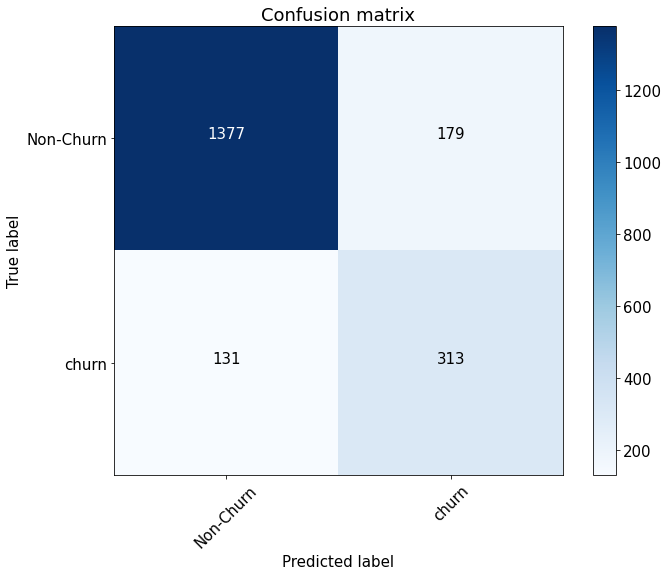

In [64]:
a=get_metrics(preds)
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>a)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [65]:
TP = cnf_matrix[1,1]
FP = cnf_matrix[0,1]

In [66]:
TP,FP

(313, 179)

In [67]:
print(f'Модель предсказала отток  {TP+FP} клиента')
print(f'Расходы на удержание предсказаных к уходу {TP+FP} долларов')
print(f'Доход от каждого правильно классифицируемого {TP*2} долларов')
print(f'Прибыль {TP*2 -(TP+FP)} долларов')

Модель предсказала отток  492 клиента
Расходы на удержание предсказаных к уходу 492 долларов
Доход от каждого правильно классифицируемого 626 долларов
Прибыль 134 долларов


#### Теперь расчитаем отсечение с точки зрения экономической выгоды

In [68]:
res= []
for i in np.arange(0.05,0.95,0.01):
    cnf_matrix = confusion_matrix(y_test, preds>i)
    TP = cnf_matrix[1,1]
    FP = cnf_matrix[0,1]
    profit = TP*2 -(TP+FP)
    res.append((i,profit))
res.sort(key = lambda x: x[1])    
best_split = res[-1][0]
max_profit = res[-1][1]
best_split,max_profit

(0.4600000000000001, 164)

#### Подняли прибыль до 164 $ 

Confusion matrix, without normalization
[[1502   54]
 [ 226  218]]


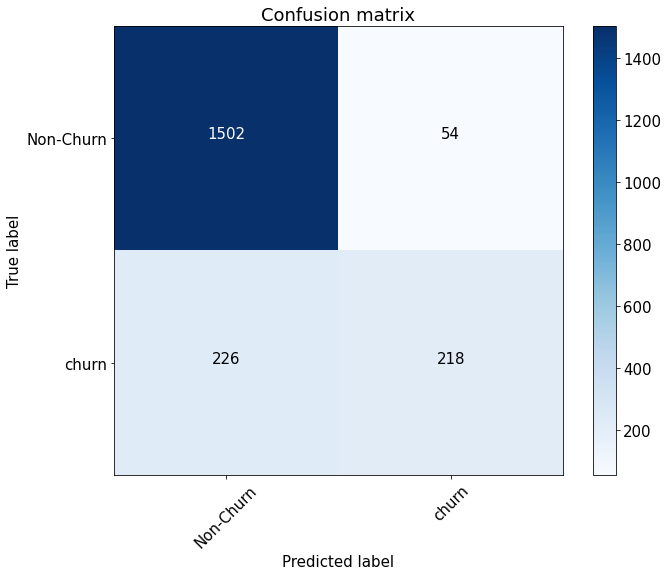

In [69]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>best_split)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [70]:
TP = cnf_matrix[1,1]
FP = cnf_matrix[0,1]
TN = cnf_matrix[0,0]
FN = cnf_matrix[1,0]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
f1 = 2*Precision*Recall/(Precision+Recall)
Precision,Recall,f1

(0.8014705882352942, 0.49099099099099097, 0.6089385474860336)

## Работа признаки

In [71]:
df_work

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [72]:
df_work['Geography'] = df_work['Geography'].map({'France':1,'Germany':2,'Spain':3})

In [73]:
df_work['Gender'] = df_work['Gender'].map({'Female':1,'Male':2})

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
850    233
678     63
655     54
705     53
667     53
      ... 
419      1
417      1
373      1
365      1
401      1
Name: CreditScore, Length: 460, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 ----------------------------------------------------------

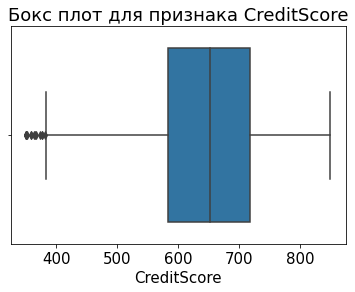

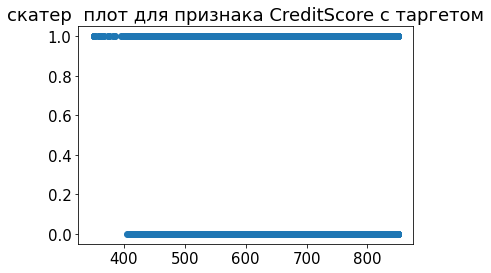

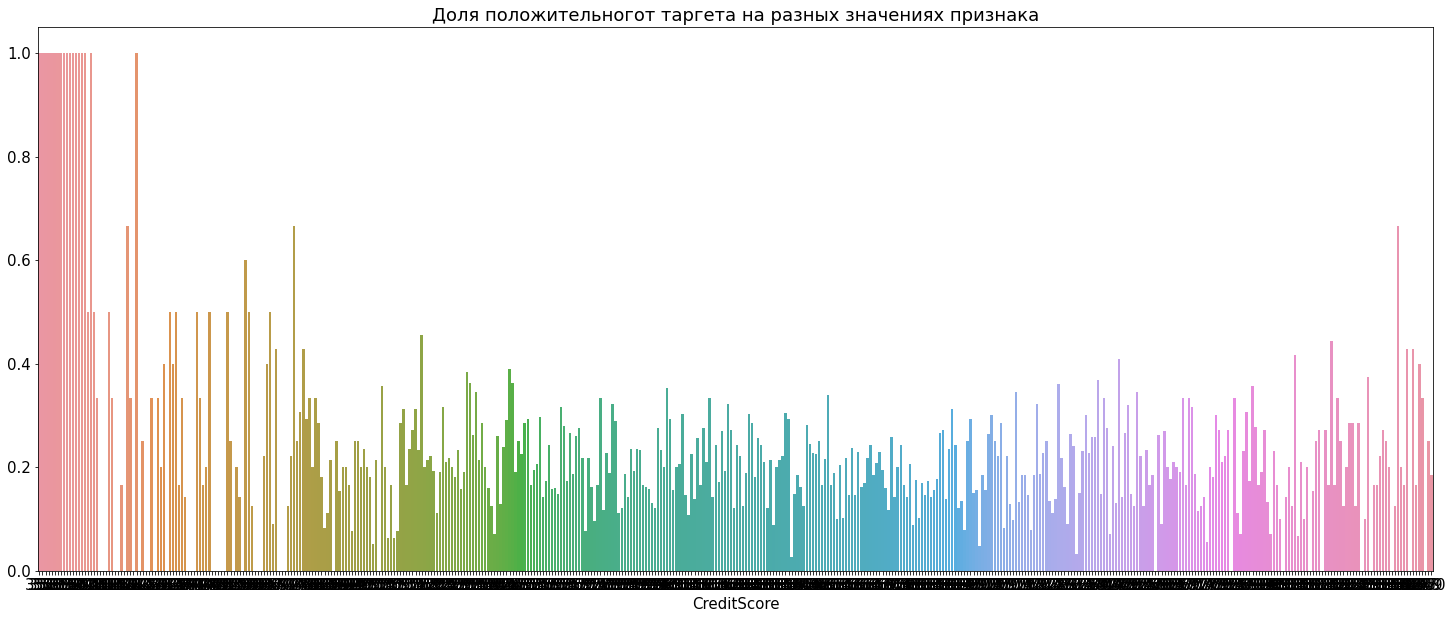

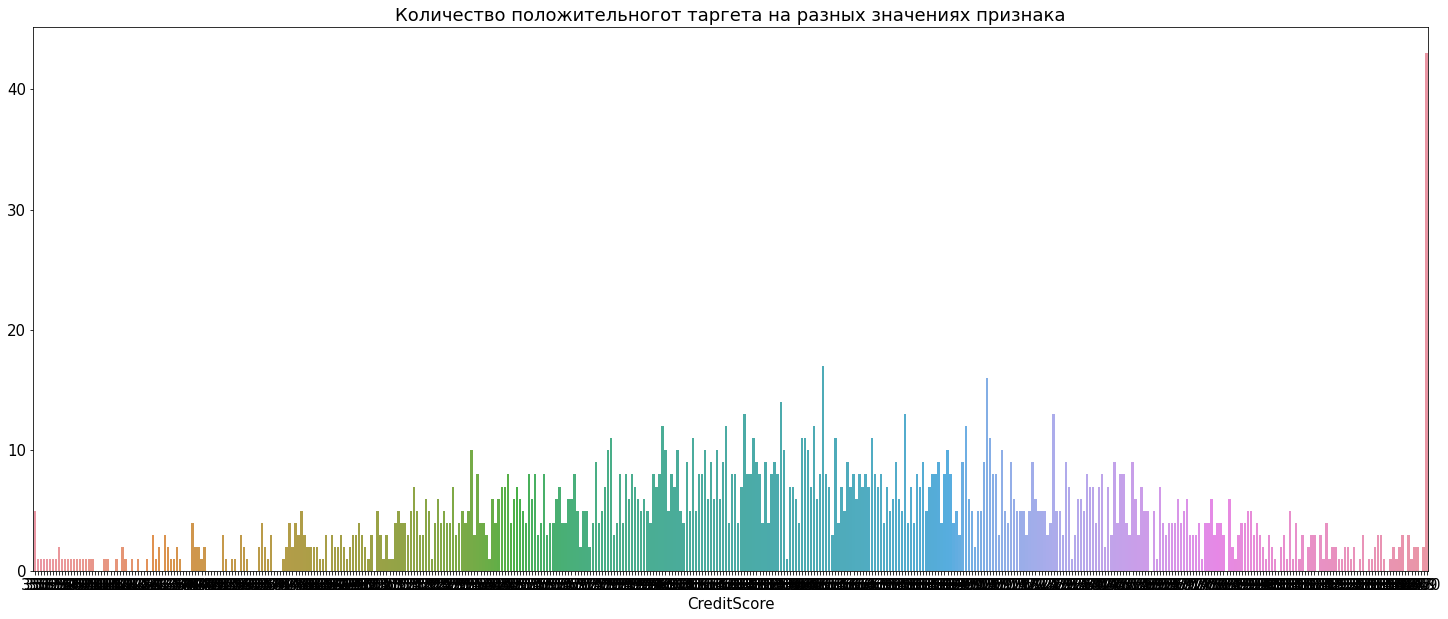

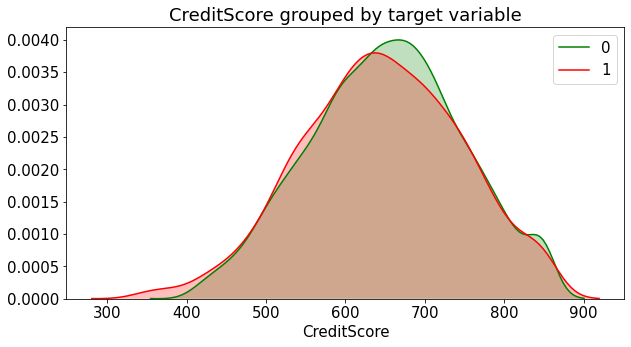

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (7839548.0, 0.00993433058636417)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


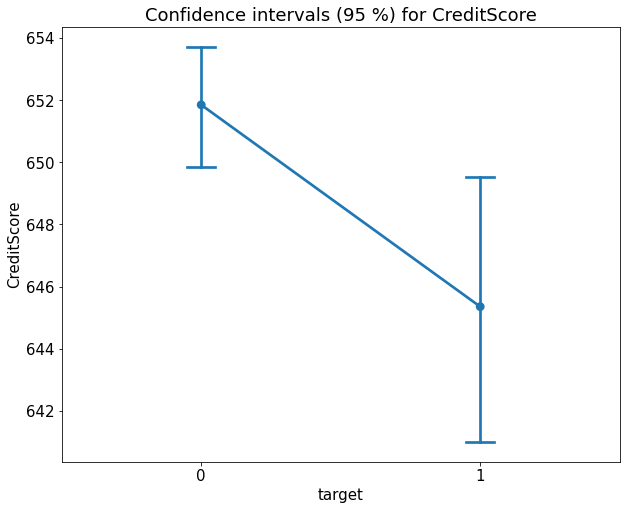

Посмотрим на корреляцию данного признака к другим
IsActiveMember     0.025651
NumOfProducts      0.012238
Geography          0.007888
Balance            0.006268
Tenure             0.000842
EstimatedSalary   -0.001384
Gender            -0.002857
Age               -0.003965
HasCrCard         -0.005458
target            -0.027094
Name: CreditScore, dtype: float64


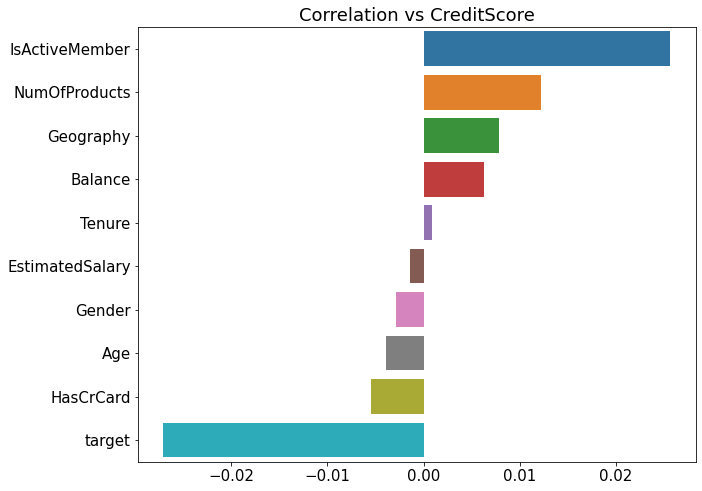

Коэф. Кендала
IsActiveMember     0.019844
NumOfProducts      0.010118
Geography          0.004714
Balance            0.004034
EstimatedSalary    0.000807
Tenure             0.000791
Gender            -0.002463
HasCrCard         -0.003110
Age               -0.005414
target            -0.019049
Name: CreditScore, dtype: float64


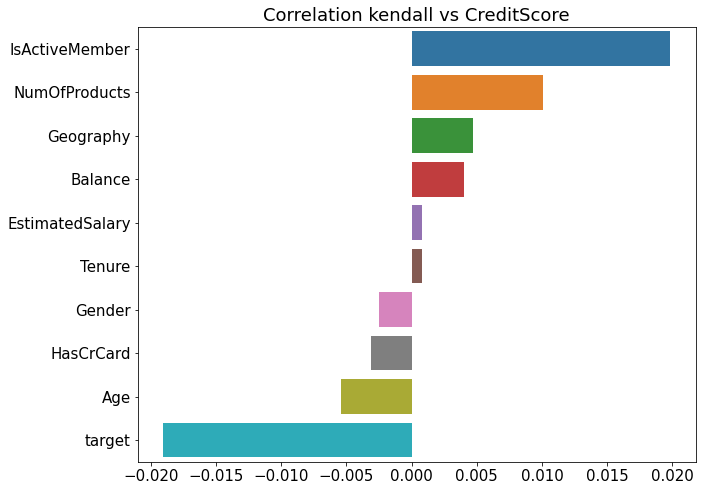

In [74]:
feature_analysis(df_work,'CreditScore','target')

In [75]:
print(120*'=')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
1    5014
2    2509
3    2477
Name: Geography, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    10000.000000
mean         1.746300
std          0.827529
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: Geography, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменной:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 -------------------

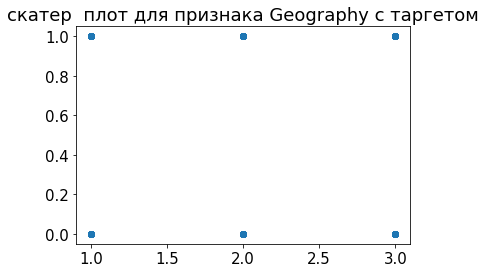

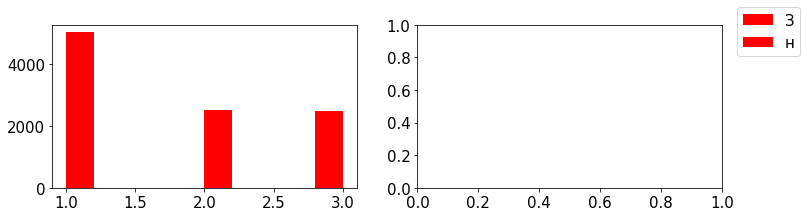

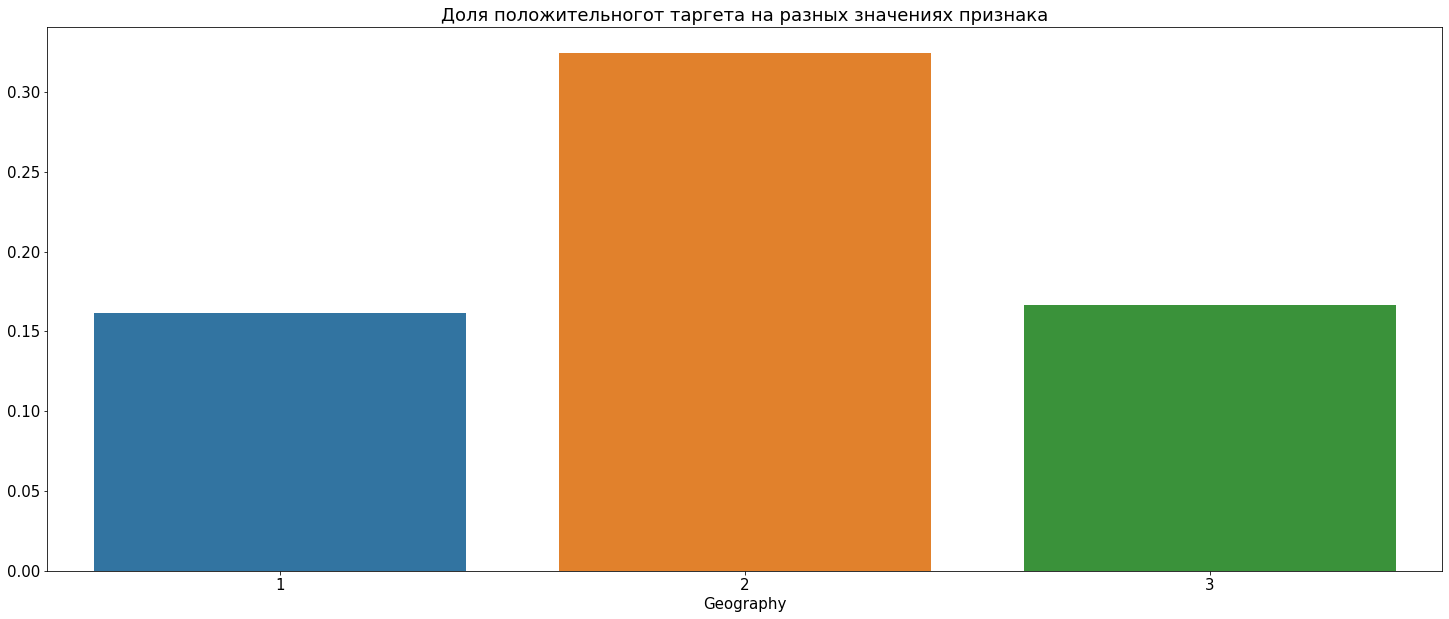

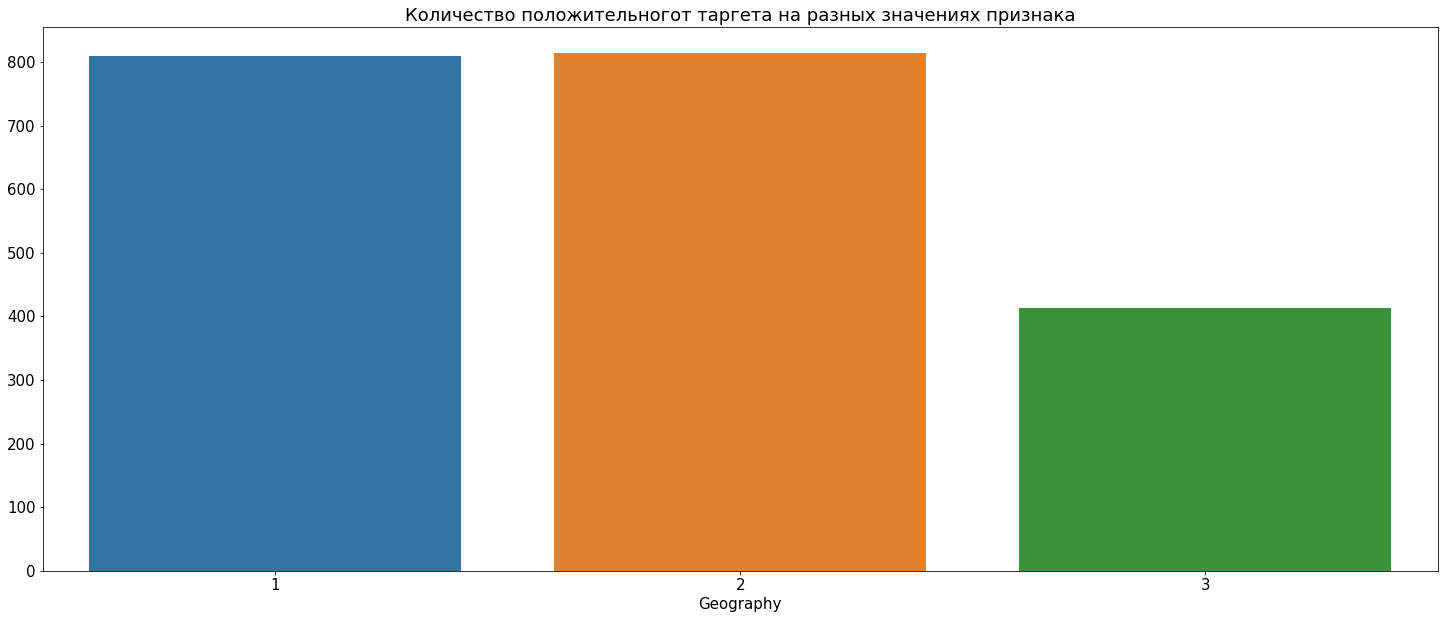

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (7543587.0, 5.513344213269543e-08)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


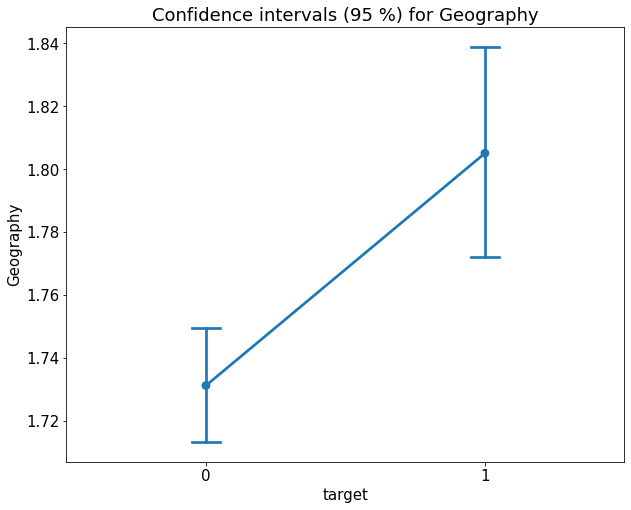

In [76]:
cat_feature_analysis(df_work,'Geography','target')

In [77]:
print(120*'=')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
2    5457
1    4543
Name: Gender, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    10000.000000
mean         1.545700
std          0.497932
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: Gender, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменной:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 -----------------------------------

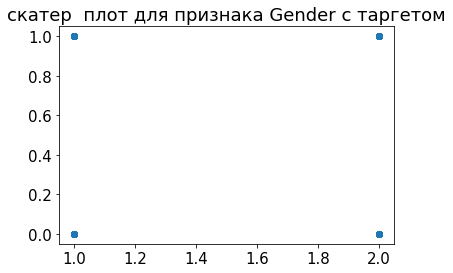

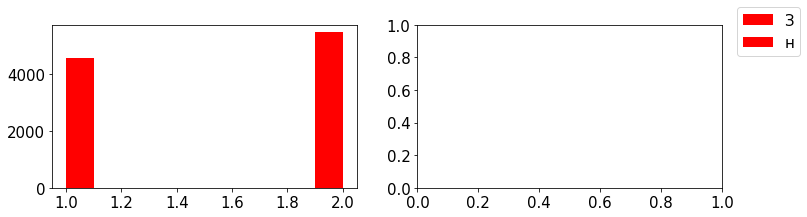

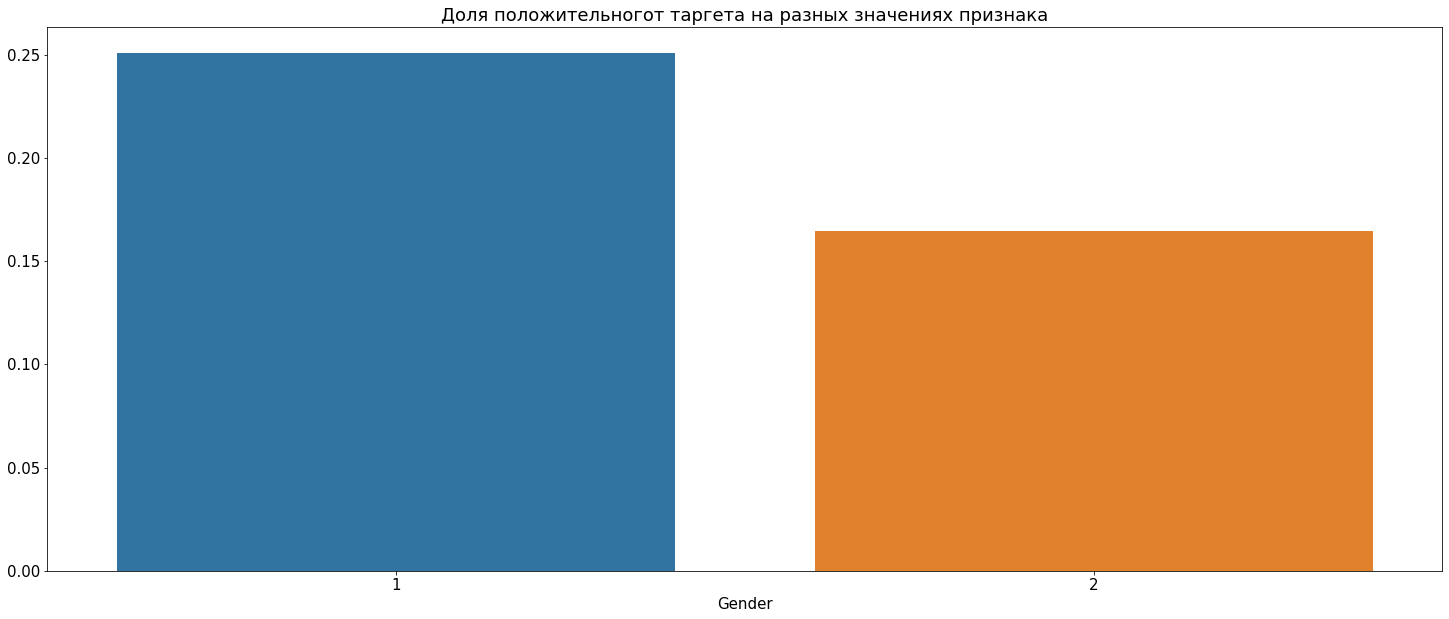

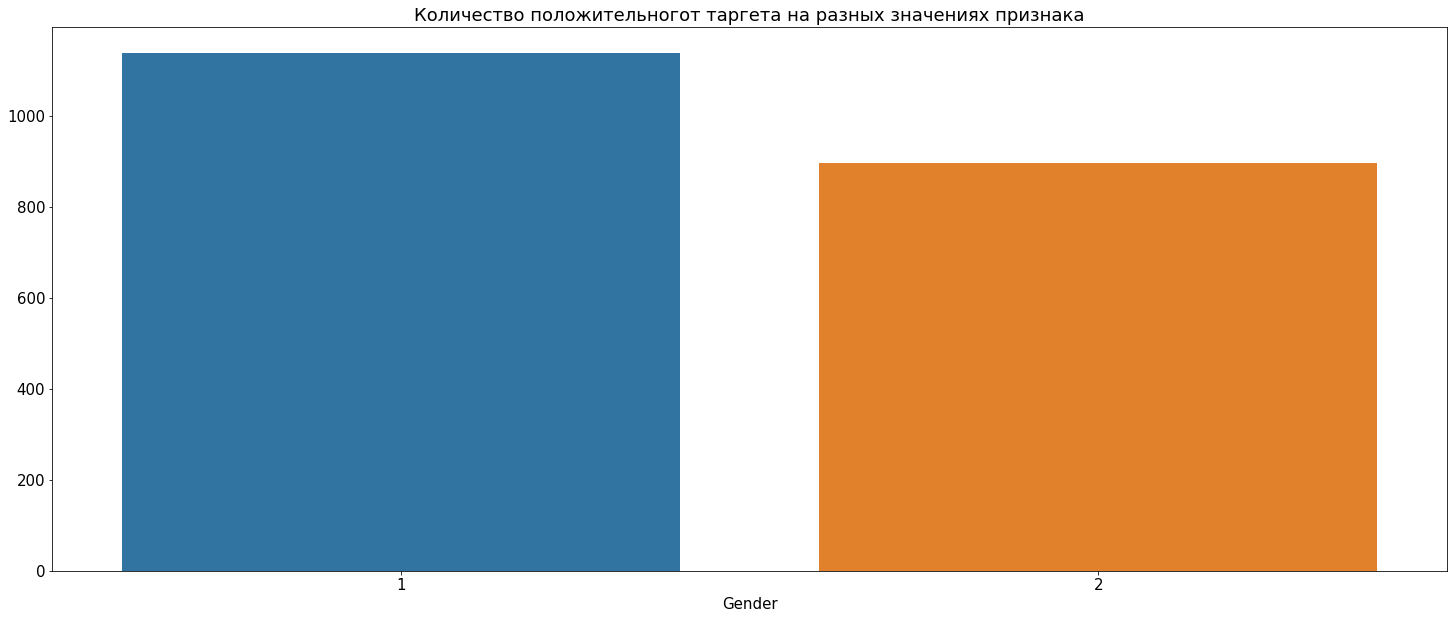

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (7042361.0, 8.651897218604673e-27)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


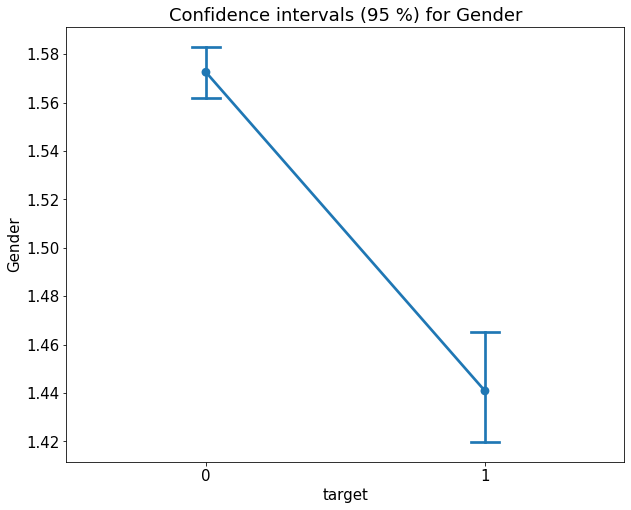

In [78]:
cat_feature_analysis(df_work,'Gender','target')

In [79]:
print(120*'=')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
88      1
82      1
85      1
83      1
Name: Age, Length: 70, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переме

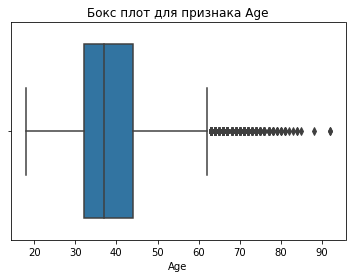

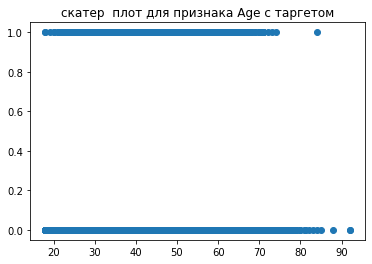

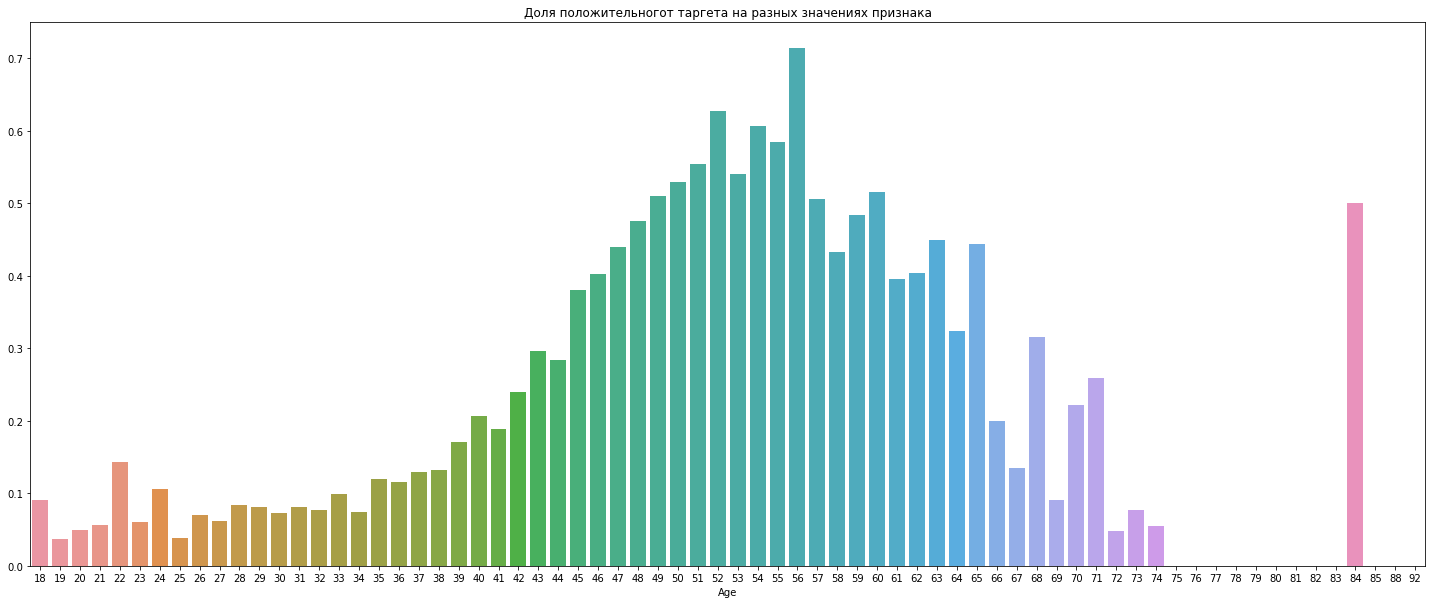

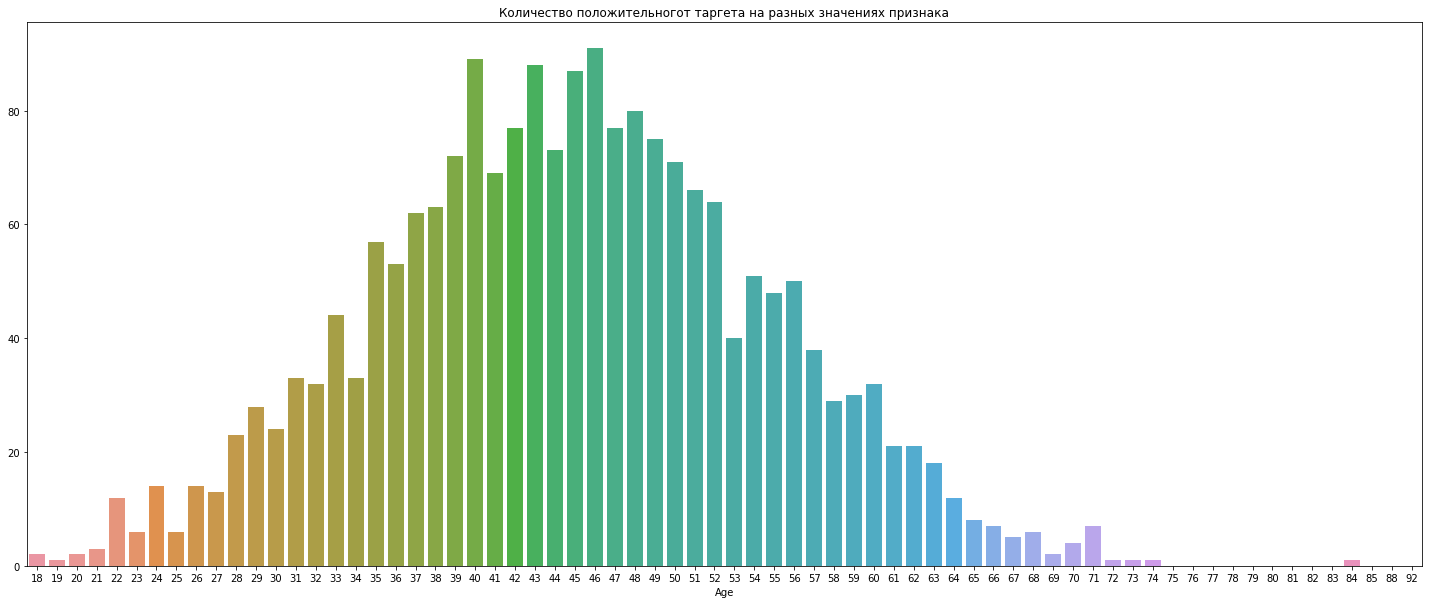

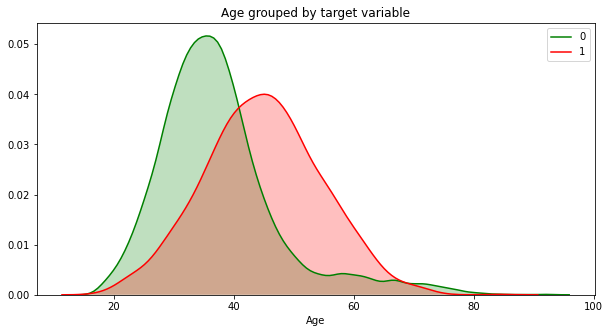

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (4345981.5, 1.6052007159685838e-230)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


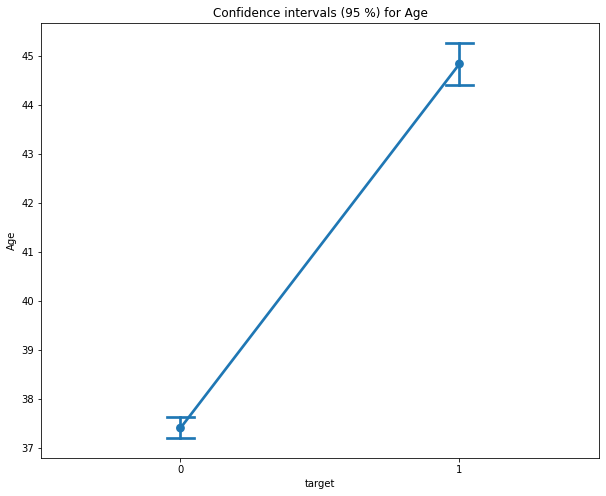

Посмотрим на корреляцию данного признака к другим
target             0.285323
IsActiveMember     0.085472
Balance            0.028308
CreditScore       -0.003965
EstimatedSalary   -0.007201
Tenure            -0.009997
HasCrCard         -0.011721
NumOfProducts     -0.030680
Name: Age, dtype: float64


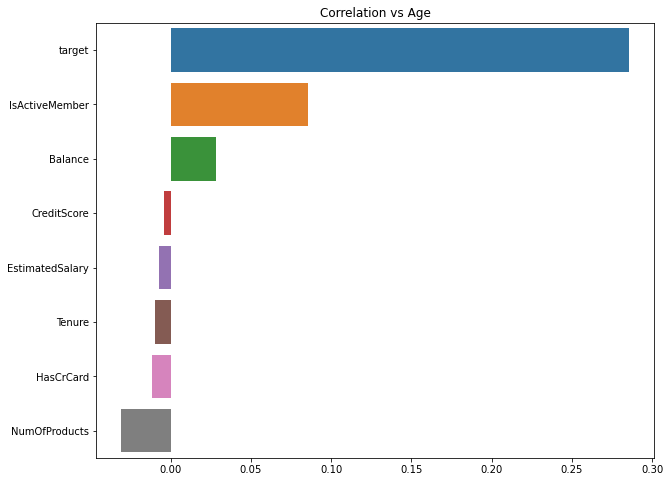

Коэф. Кендала
target             0.268573
IsActiveMember     0.033027
Balance            0.023611
EstimatedSalary   -0.001571
CreditScore       -0.005414
Tenure            -0.007424
HasCrCard         -0.012666
NumOfProducts     -0.047761
Name: Age, dtype: float64


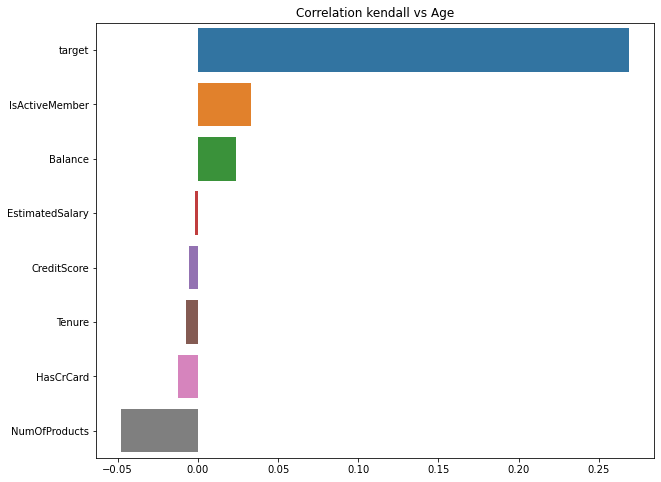

In [43]:
feature_analysis(df_work,'Age','target')

In [80]:
print(120*'=')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой п

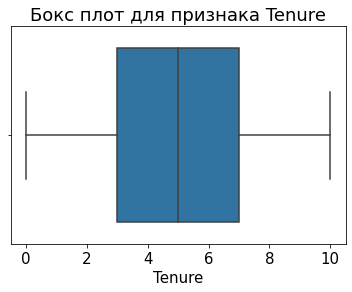

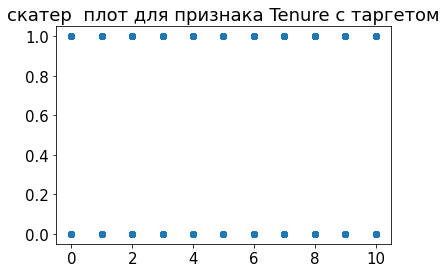

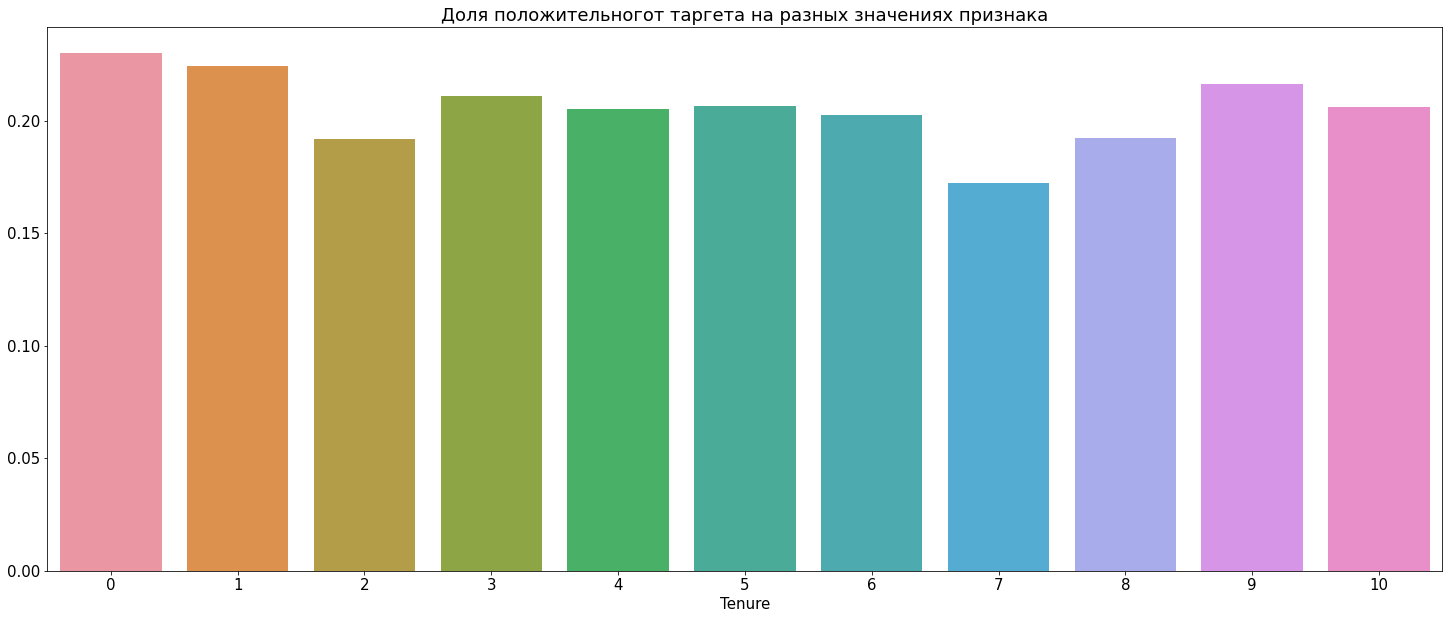

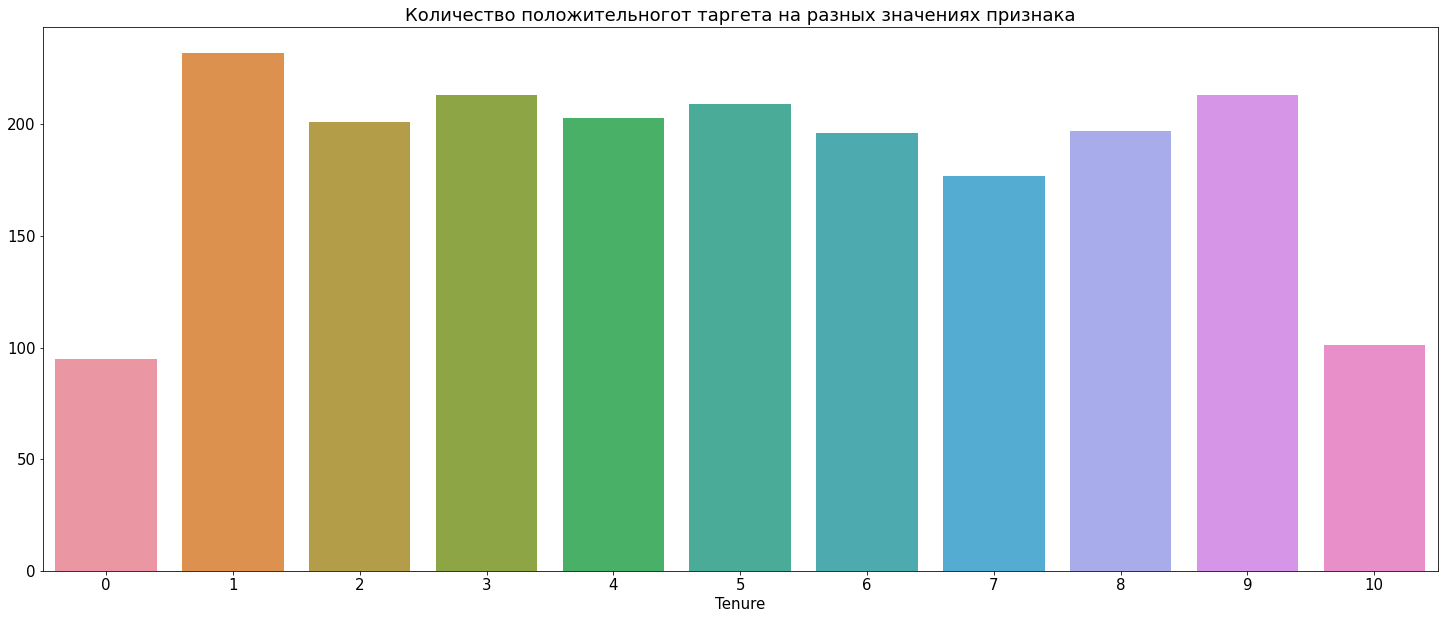

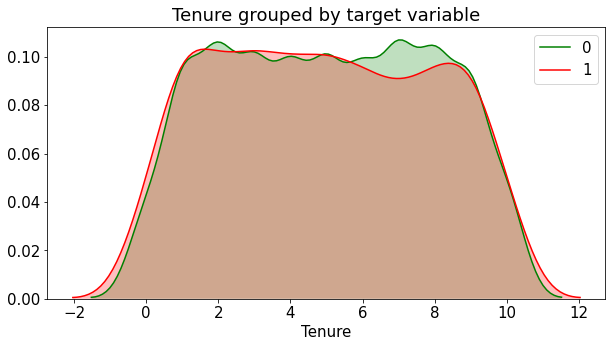

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (7948575.5, 0.08109688061459414)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


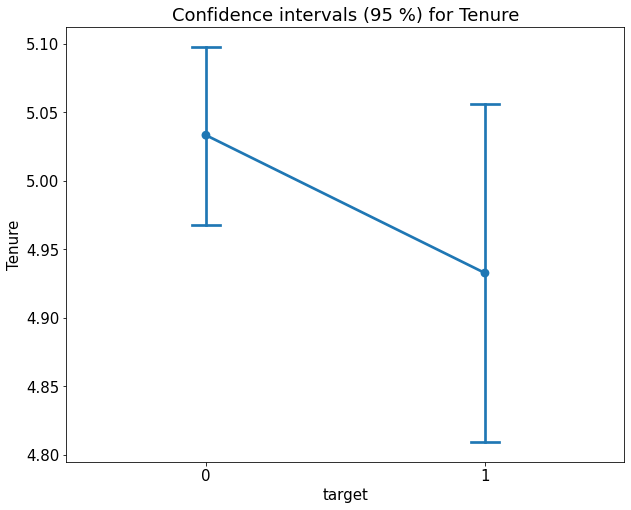

Посмотрим на корреляцию данного признака к другим
HasCrCard          0.022583
Gender             0.014733
NumOfProducts      0.013444
EstimatedSalary    0.007784
Geography          0.003739
CreditScore        0.000842
Age               -0.009997
Balance           -0.012254
target            -0.014001
IsActiveMember    -0.028362
Name: Tenure, dtype: float64


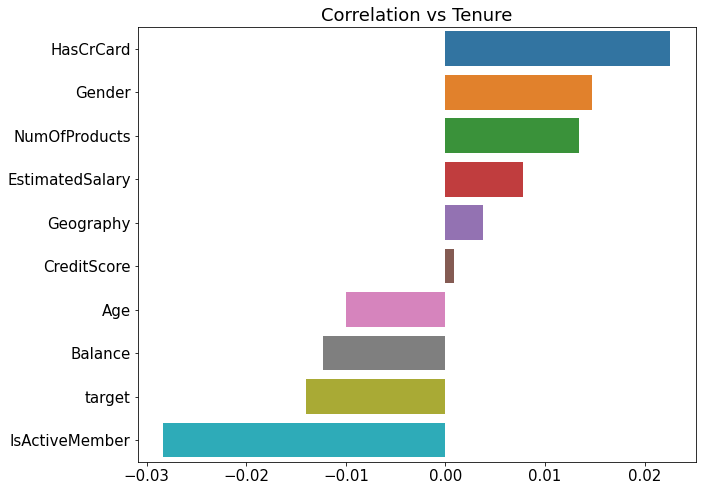

Коэф. Кендала
HasCrCard          0.019107
Gender             0.012903
NumOfProducts      0.010866
EstimatedSalary    0.005423
Geography          0.003024
CreditScore        0.000791
Balance           -0.007016
Age               -0.007424
target            -0.011947
IsActiveMember    -0.024508
Name: Tenure, dtype: float64


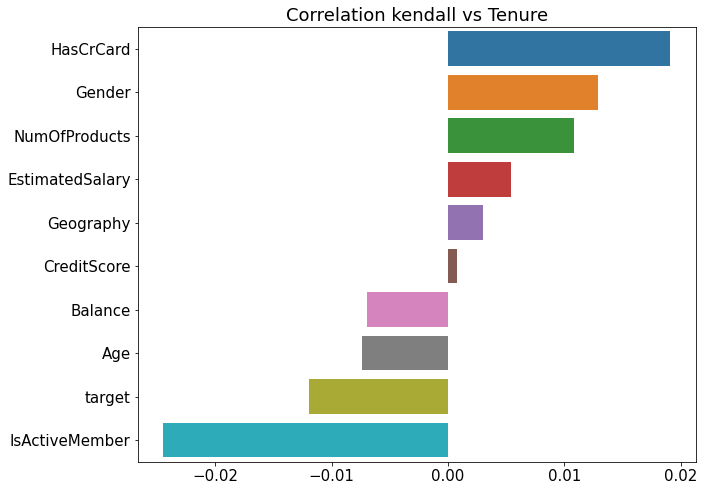

In [81]:
feature_analysis(df_work,'Tenure','target')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
0.00         3617
105473.74       2
130170.82       2
113063.83       1
80242.37        1
             ... 
183555.24       1
137648.41       1
112689.95       1
115465.28       1
74681.90        1
Name: Balance, Length: 6382, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: targe

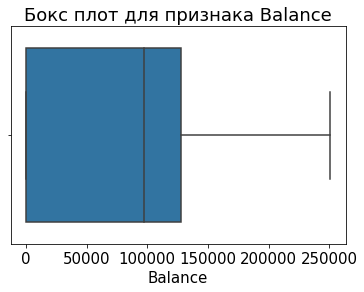

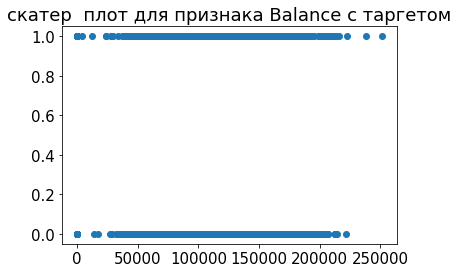

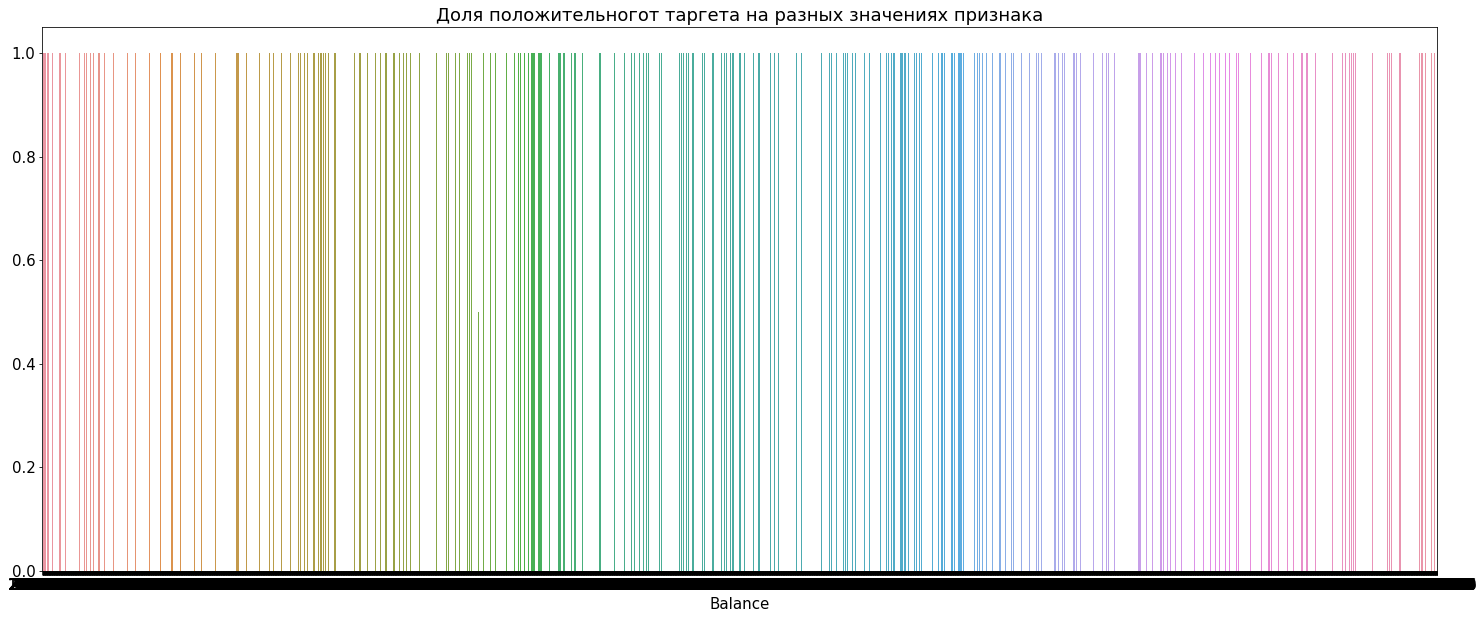

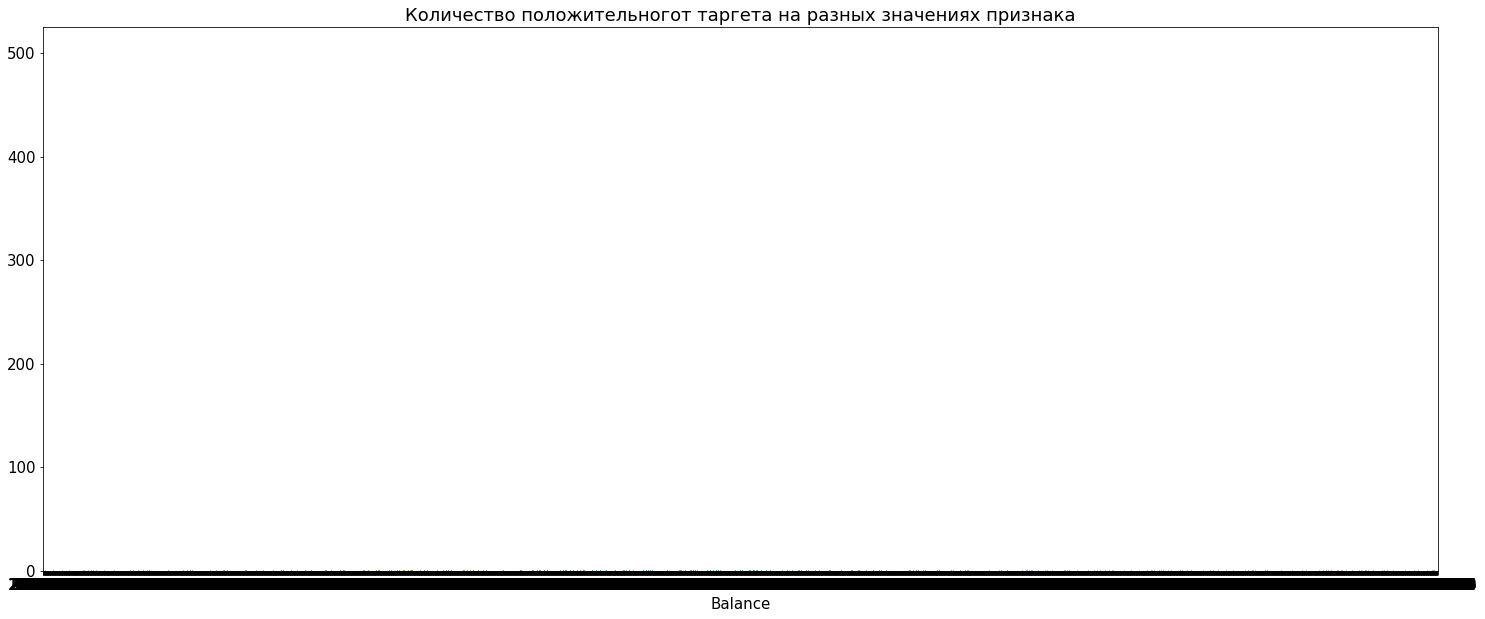

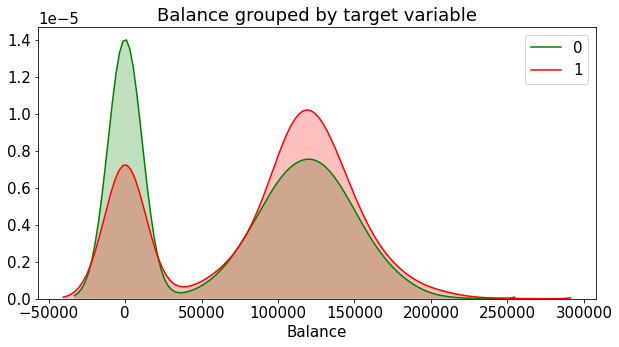

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (6849444.5, 5.579199689574611e-29)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


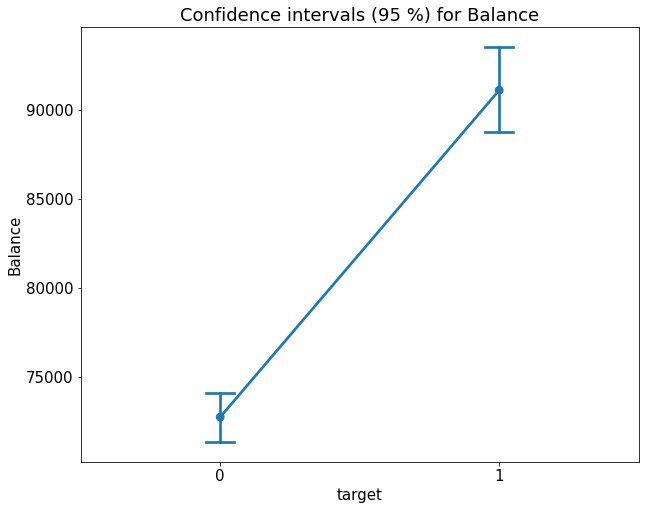

Посмотрим на корреляцию данного признака к другим
target             0.118533
Geography          0.069408
Age                0.028308
EstimatedSalary    0.012797
Gender             0.012087
CreditScore        0.006268
IsActiveMember    -0.010084
Tenure            -0.012254
HasCrCard         -0.014858
NumOfProducts     -0.304180
Name: Balance, dtype: float64


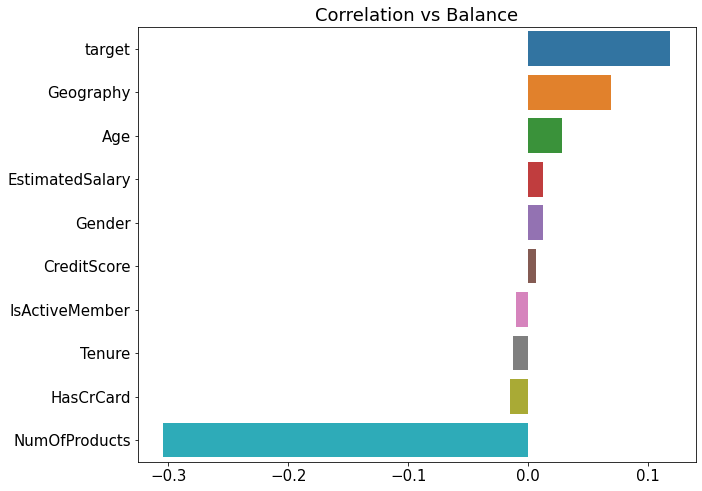

Коэф. Кендала
target             0.094983
Geography          0.080403
Age                0.023611
Gender             0.011544
EstimatedSalary    0.008200
CreditScore        0.004034
Tenure            -0.007016
HasCrCard         -0.008407
IsActiveMember    -0.009828
NumOfProducts     -0.266748
Name: Balance, dtype: float64


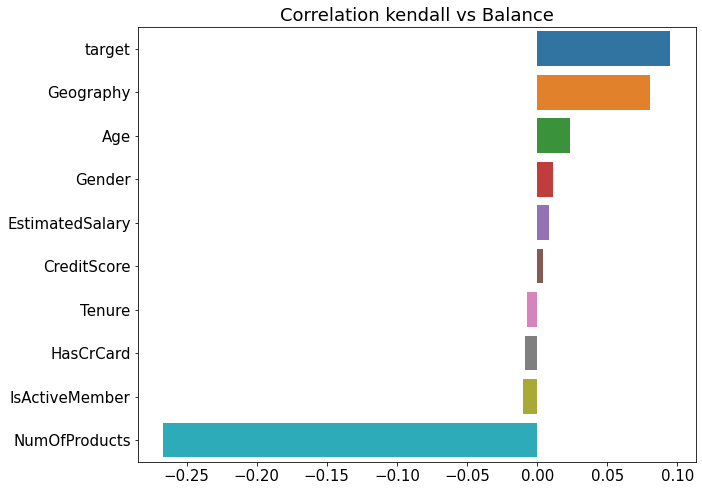

In [82]:
feature_analysis(df_work,'Balance','target')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: NumOfProducts, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменной:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 -

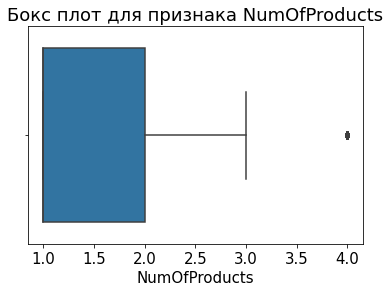

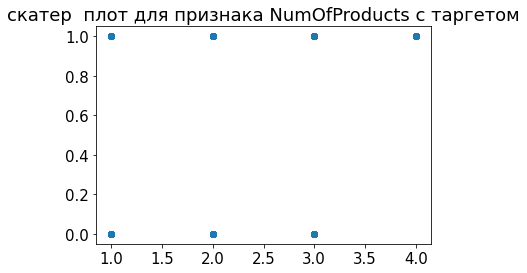

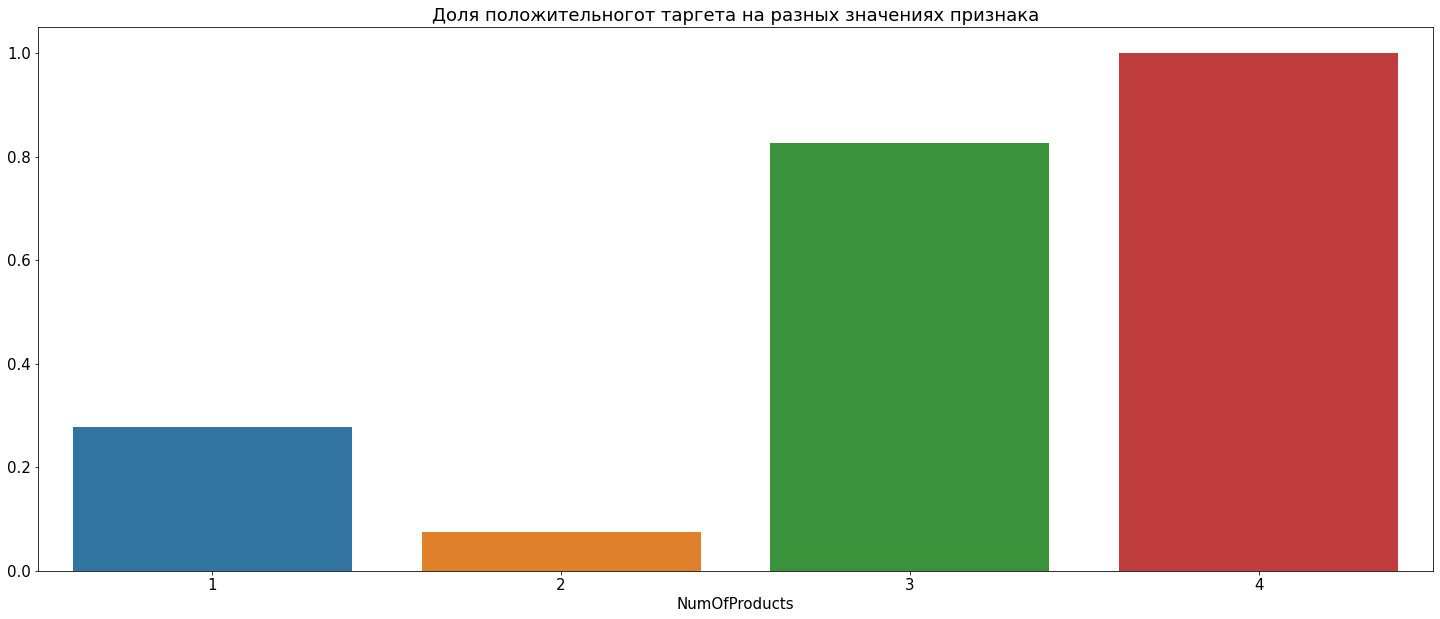

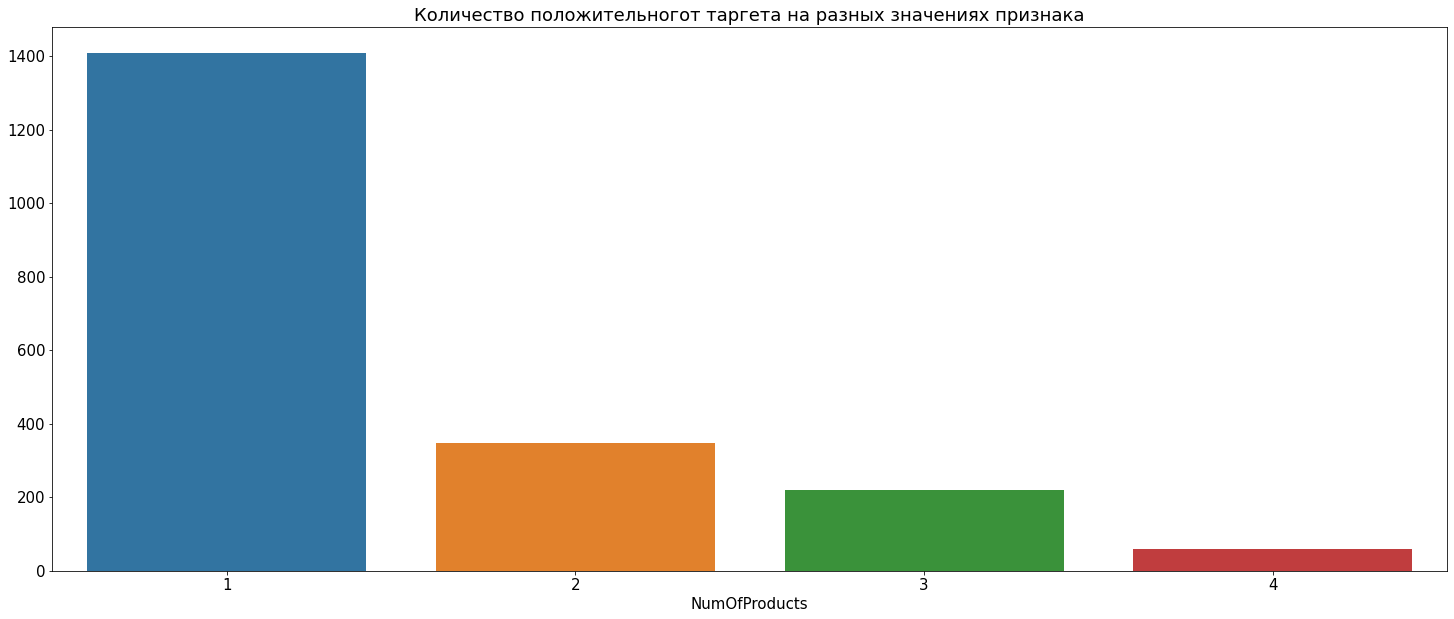

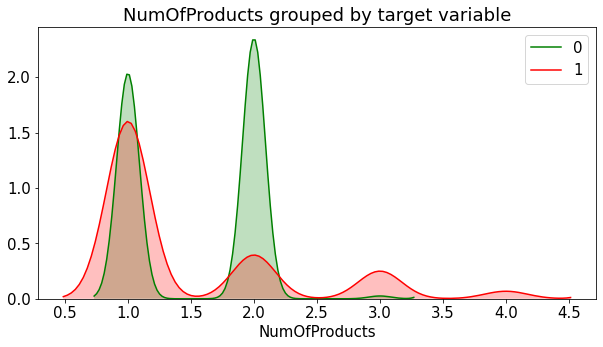

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (6830625.5, 2.637552606408597e-36)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


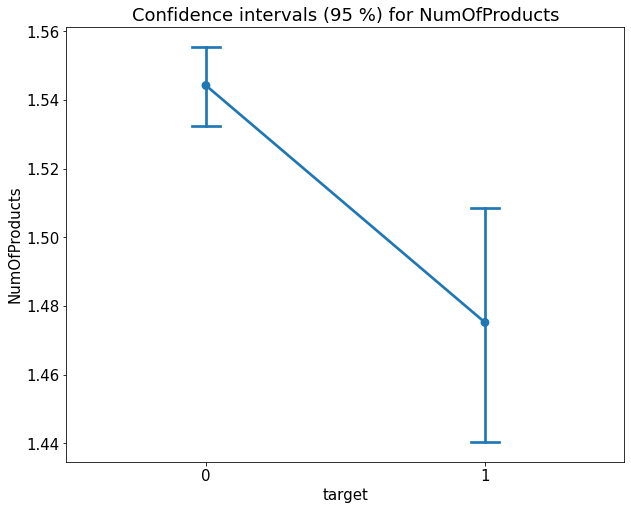

Посмотрим на корреляцию данного признака к другим
EstimatedSalary    0.014204
Tenure             0.013444
CreditScore        0.012238
IsActiveMember     0.009612
Geography          0.003972
HasCrCard          0.003183
Gender            -0.021859
Age               -0.030680
target            -0.047820
Balance           -0.304180
Name: NumOfProducts, dtype: float64


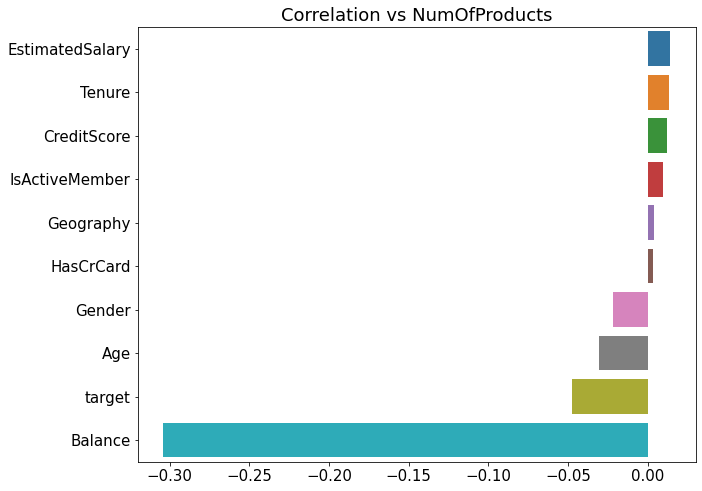

Коэф. Кендала
IsActiveMember     0.016051
Tenure             0.010866
EstimatedSalary    0.010130
CreditScore        0.010118
HasCrCard          0.003802
Geography          0.000680
Gender            -0.012661
Age               -0.047761
target            -0.123434
Balance           -0.266748
Name: NumOfProducts, dtype: float64


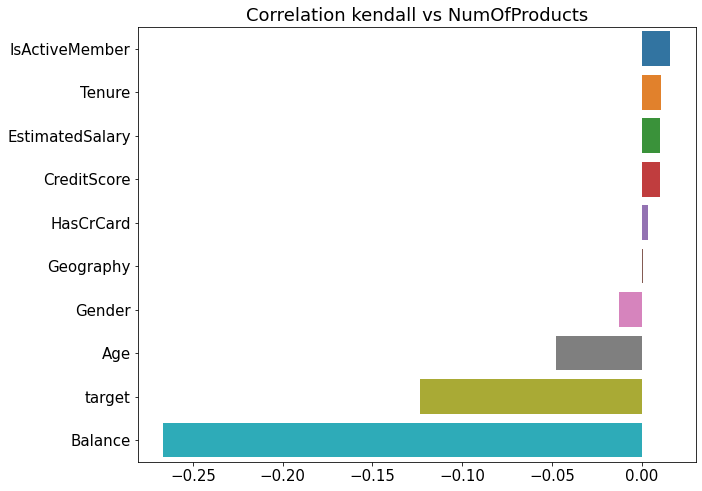

In [83]:
feature_analysis(df_work,'NumOfProducts','target')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
1    7055
0    2945
Name: HasCrCard, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    10000.00000
mean         0.70550
std          0.45584
min          0.00000
25%          0.00000
50%          1.00000
75%          1.00000
max          1.00000
Name: HasCrCard, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменной:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 -------------------------------------

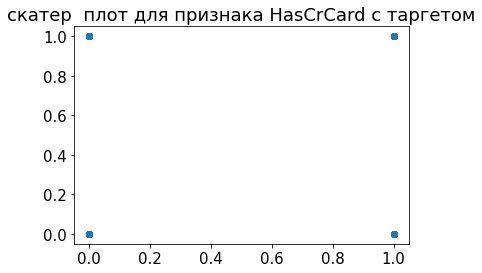

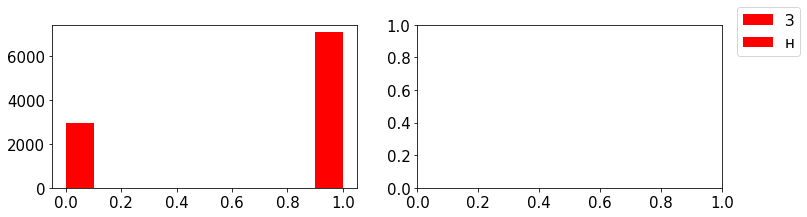

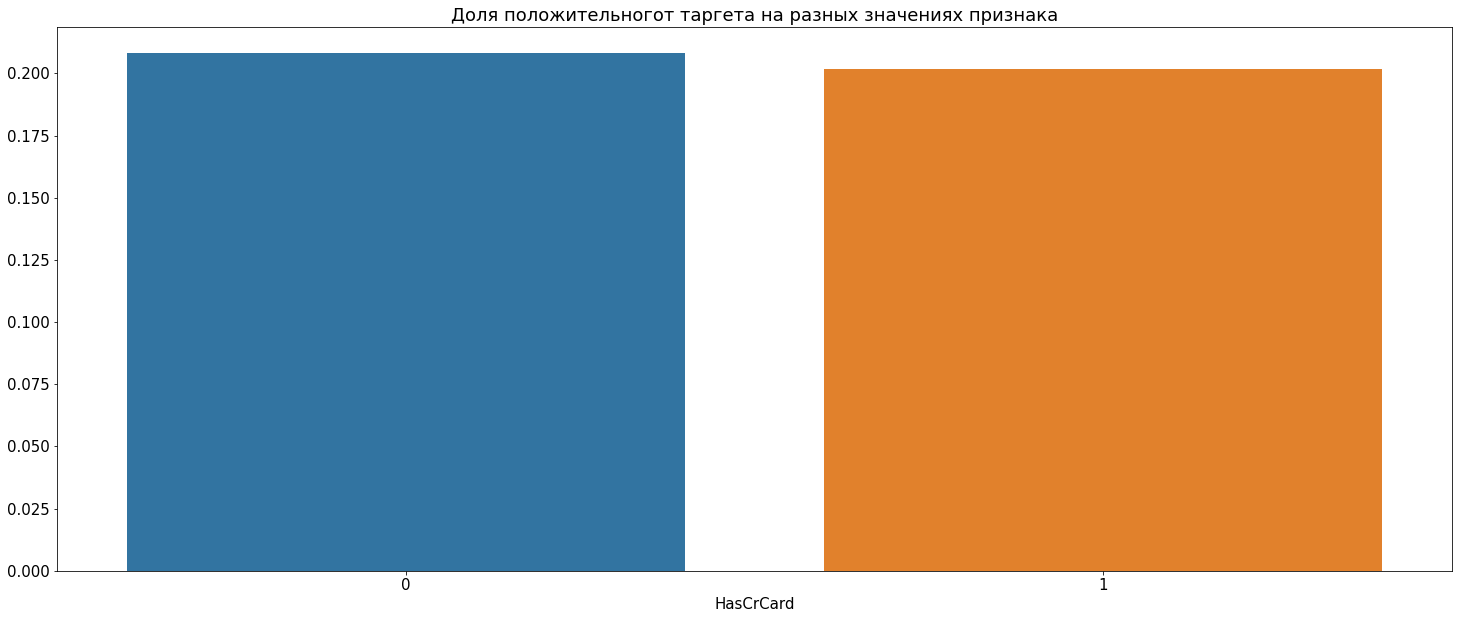

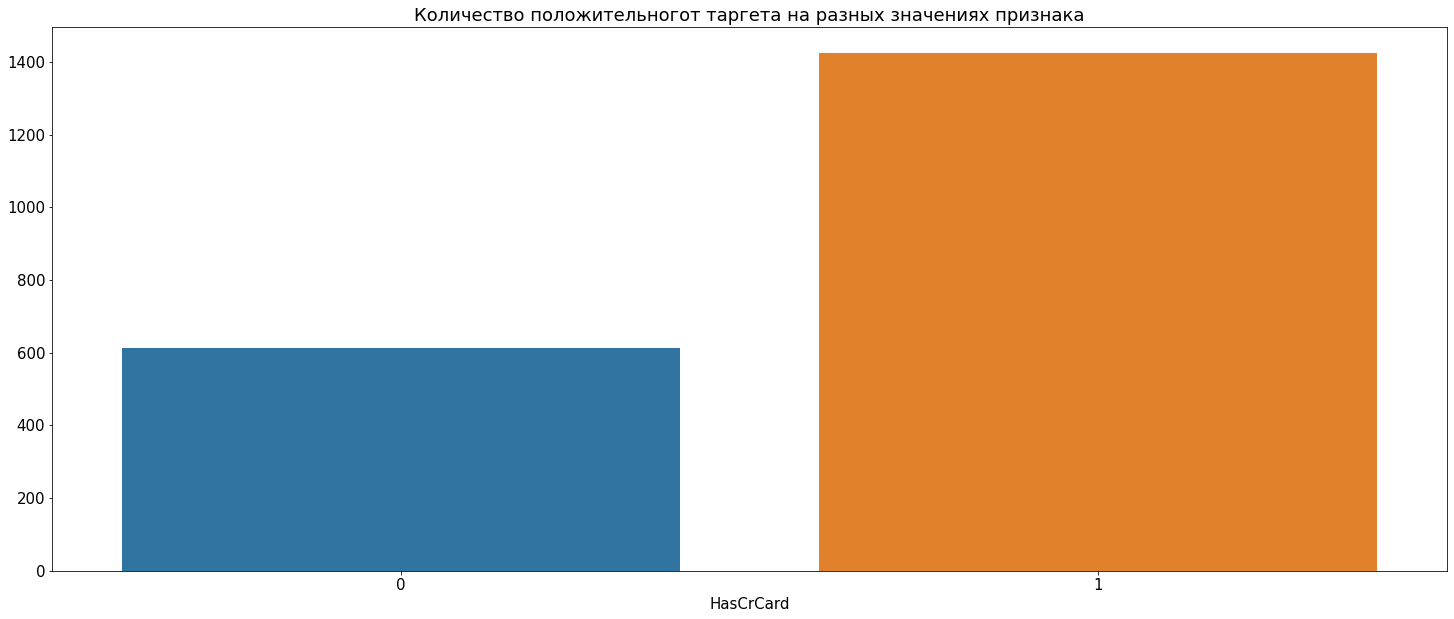

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (8044798.0, 0.23769539877404516)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


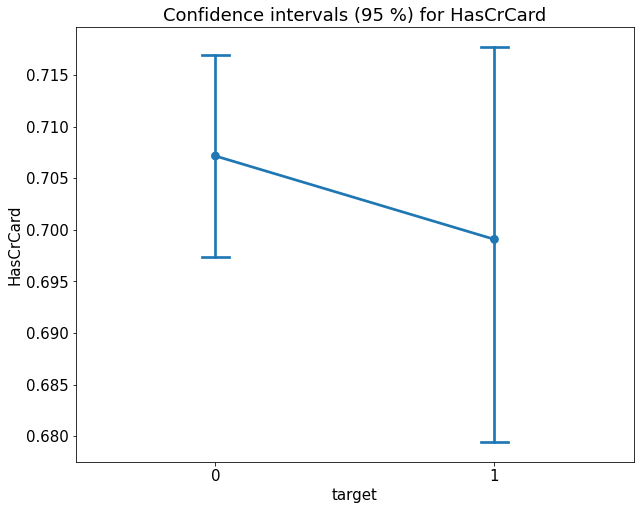

In [84]:
cat_feature_analysis(df_work,'HasCrCard','target')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
1    5151
0    4849
Name: IsActiveMember, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    10000.000000
mean         0.515100
std          0.499797
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: IsActiveMember, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменной:
0    0.7963
1    0.2037
Name: target, dtype: float64 
 -------------------

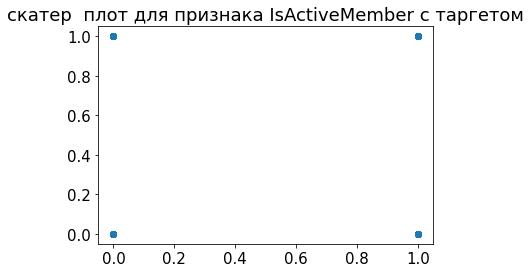

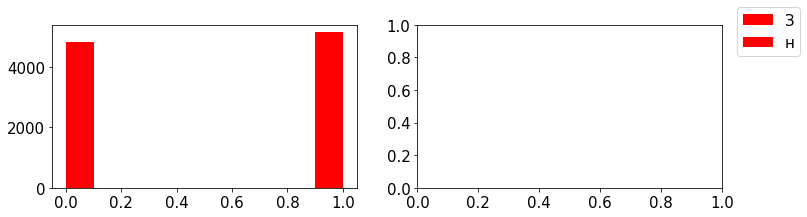

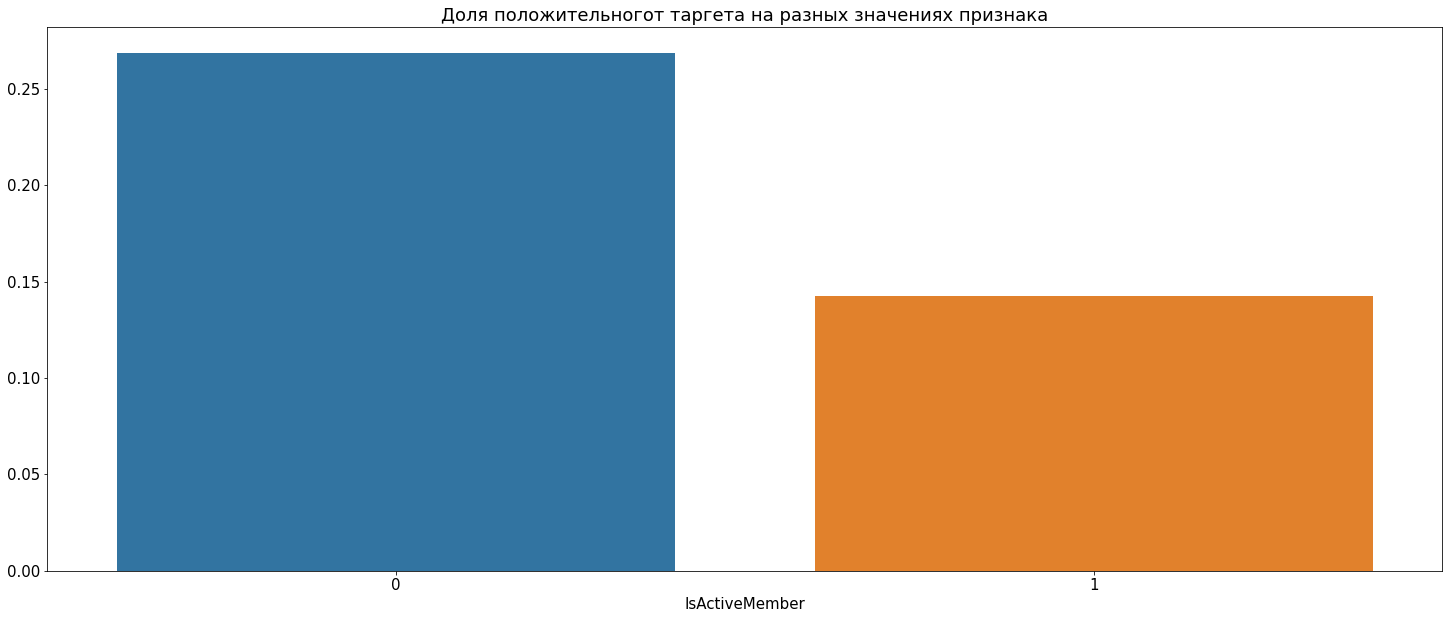

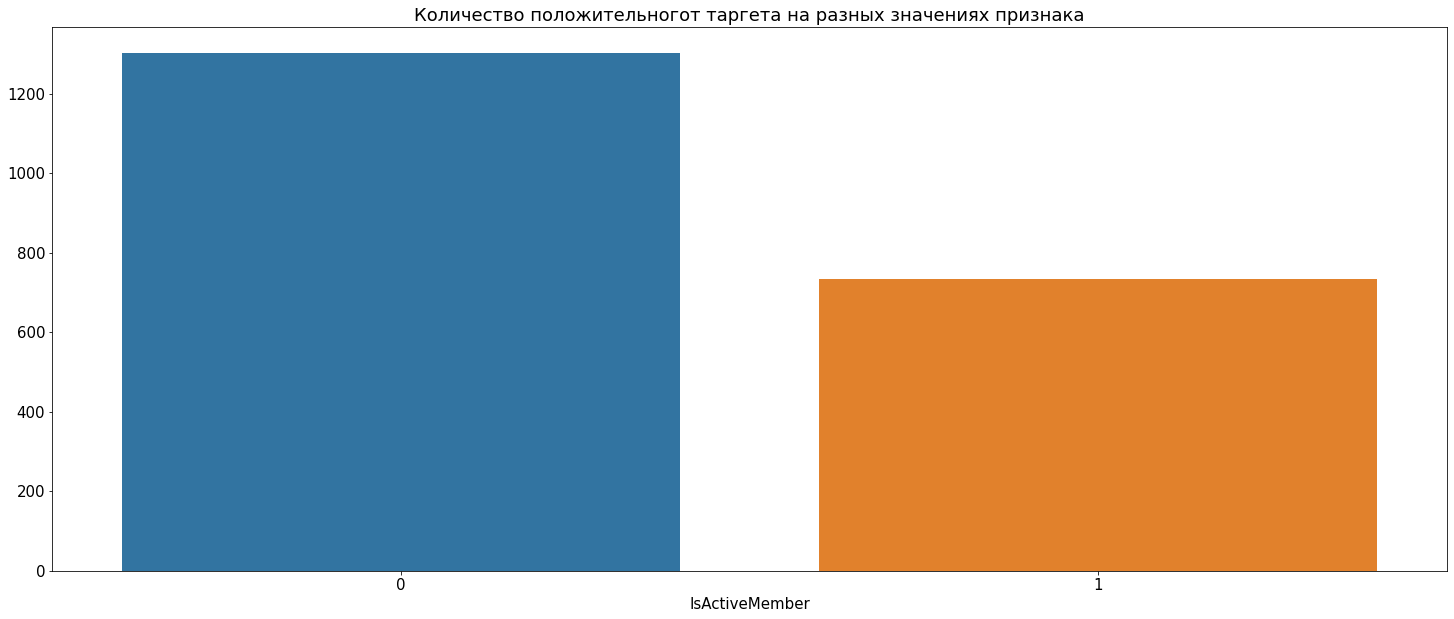

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (6539022.0, 3.0138152767839447e-55)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


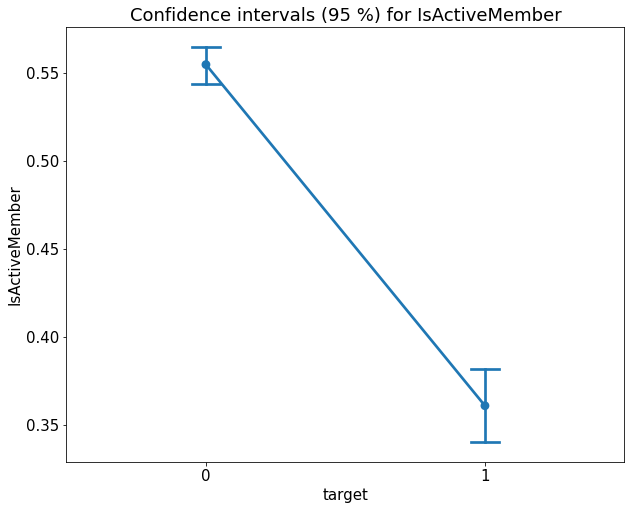

In [85]:
cat_feature_analysis(df_work,'IsActiveMember','target')

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
24924.92     2
109029.72    1
182025.95    1
82820.85     1
30314.04     1
            ..
158302.59    1
171037.63    1
43036.60     1
55034.02     1
104181.78    1
Name: EstimatedSalary, Length: 9999, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: target, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7963
1    0.2037
Name: target, dtype: float64

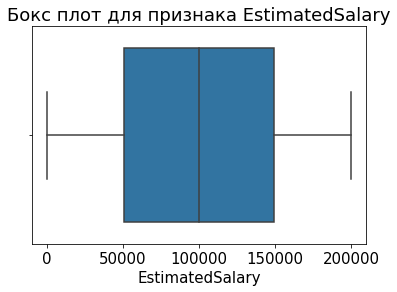

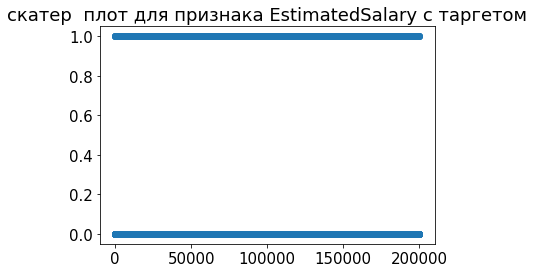

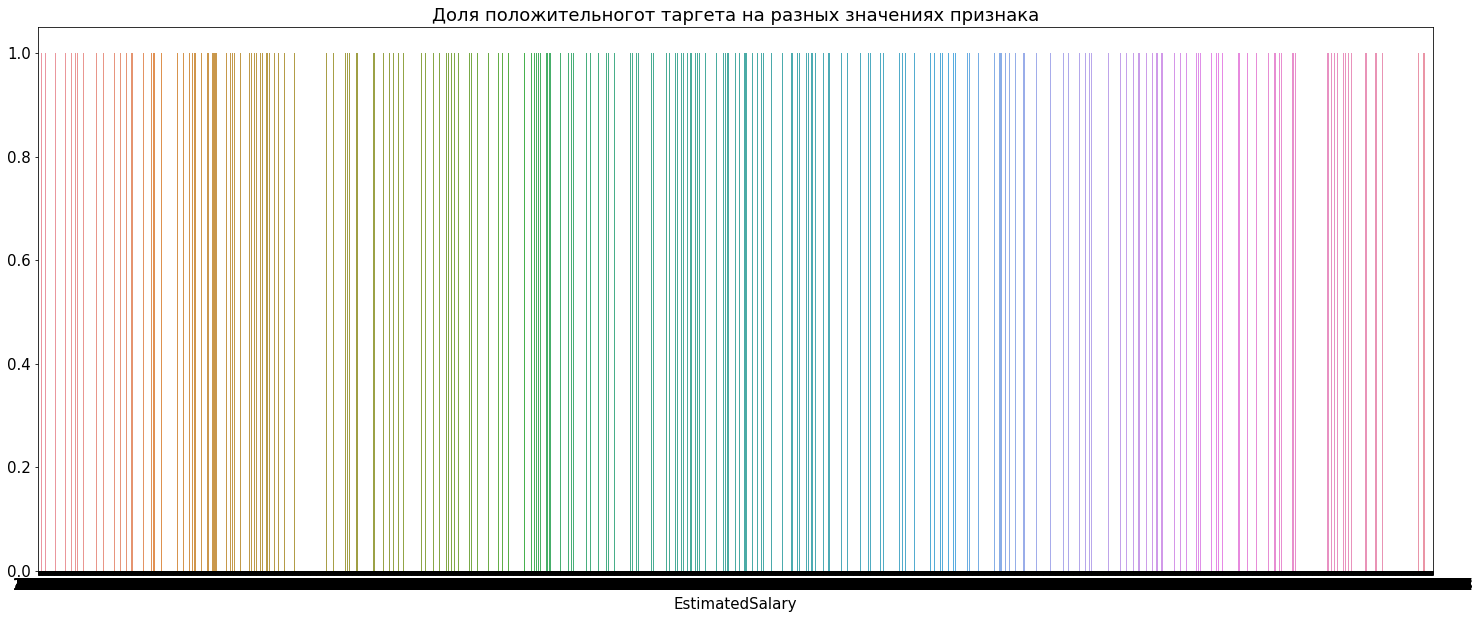

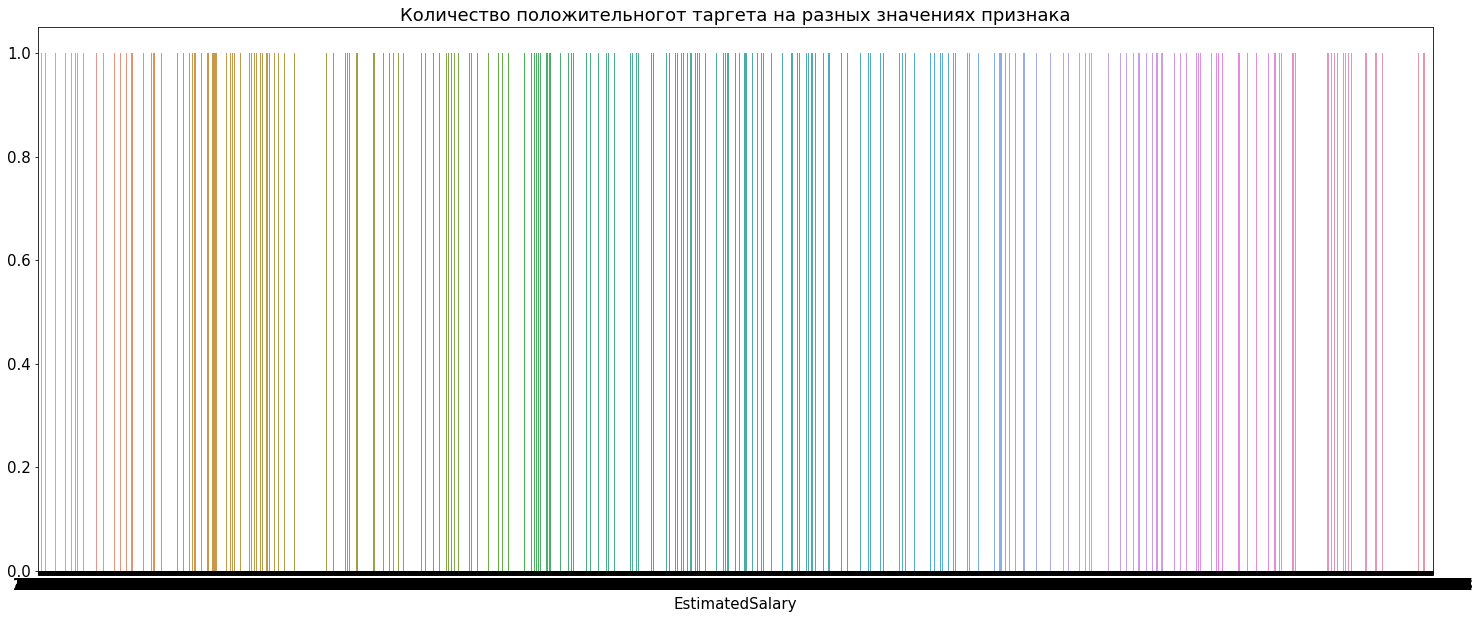

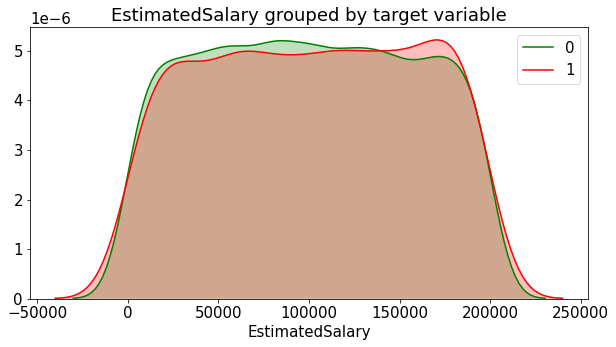

Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (7969863.0, 0.11352575465076892)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


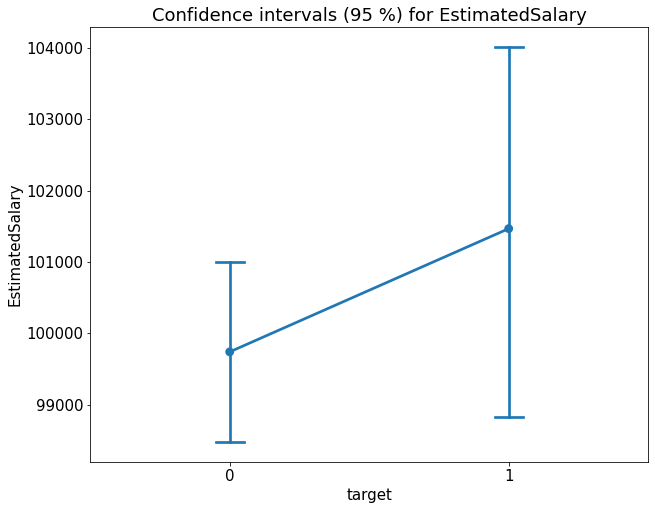

Посмотрим на корреляцию данного признака к другим
NumOfProducts     0.014204
Balance           0.012797
target            0.012097
Tenure            0.007784
Geography        -0.001369
CreditScore      -0.001384
Age              -0.007201
Gender           -0.008112
HasCrCard        -0.009933
IsActiveMember   -0.011421
Name: EstimatedSalary, dtype: float64


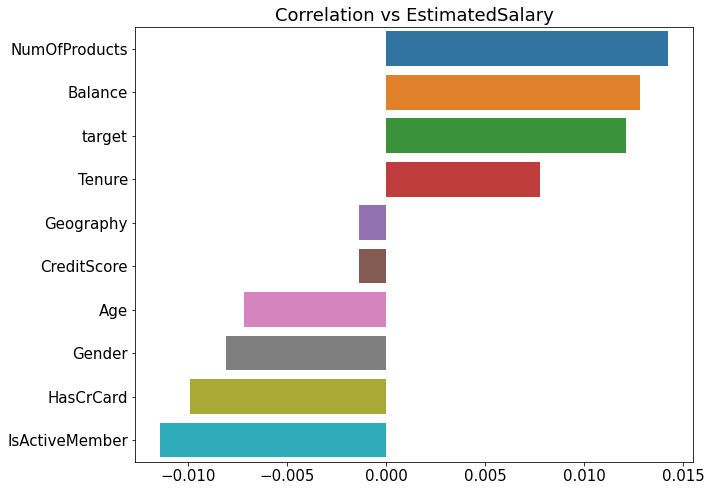

Коэф. Кендала
NumOfProducts     0.010130
target            0.009864
Balance           0.008200
Tenure            0.005423
CreditScore       0.000807
Geography        -0.000170
Age              -0.001571
Gender           -0.006752
HasCrCard        -0.008199
IsActiveMember   -0.009365
Name: EstimatedSalary, dtype: float64


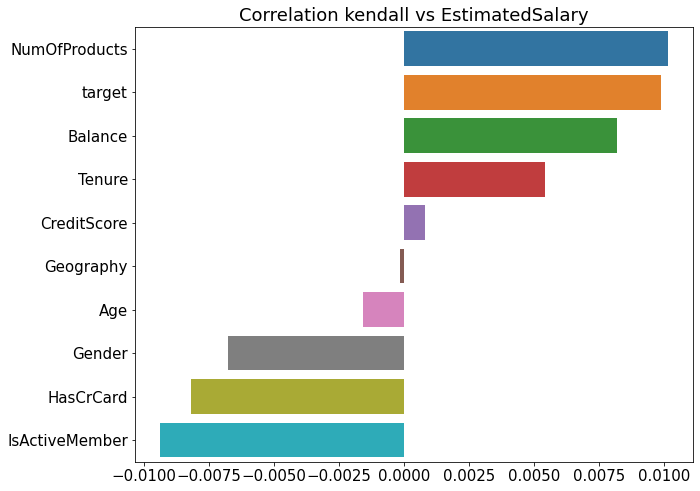

In [86]:
feature_analysis(df_work,'EstimatedSalary','target')

### Посмотрим на важность признаков

In [87]:
columns = ['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_1',
 'Geography_2',
 'Geography_3', 
 'Gender_1',
 'Gender_2'          
 ]

imported_line = estimators[0][1].fit(df_1.drop('target',1),
                          df_1['target'])['classifier']
imported_line=imported_line.coef_[0]
imported_line = np.abs(imported_line)
std= estimators[0][1]['features'].fit_transform(df_1.drop('target',1)).std(axis =0)
imported_line = imported_line*std
imported_line = list(zip(columns,imported_line))
imported_line.sort(key = lambda x: x[1],reverse=True)  
x = [i[0] for i in imported_line]
y = [i[1] for i in imported_line]

In [88]:
imported_line

[('IsActiveMember', 0.5619664145204487),
 ('Gender_1', 0.3689934830197444),
 ('HasCrCard', 0.2647171311324022),
 ('Balance', 0.22186049506969704),
 ('Geography_1', 0.15429325652786544),
 ('Age', 0.13876359205019922),
 ('NumOfProducts', 0.08816252745697674),
 ('CreditScore', 0.048443303107175935),
 ('Geography_2', 0.04434637003367034),
 ('EstimatedSalary', 0.030743056268102587),
 ('Tenure', 0.024472617360405857),
 ('Gender_2', 0.021076630414757755),
 ('Geography_3', 0.012353639403674404)]

<BarContainer object of 13 artists>

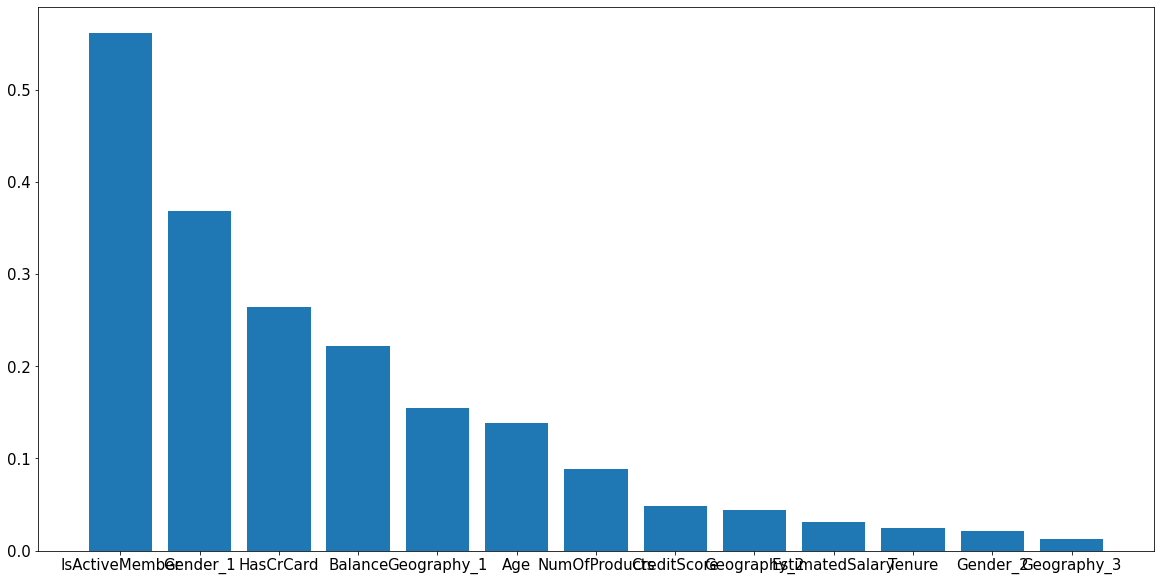

In [89]:
fig = plt.figure(figsize=[20,10])
plt.bar(x,y)

Не линейная связь

In [90]:
rf = estimators[1][1].fit(df_1.drop('target',1),df_1['target'])

In [91]:
imported_line=rf.feature_importances_
imported_line = list(zip(df_1.drop('target',1).columns.to_list(),imported_line))
imported_line.sort(key = lambda x: x[1],reverse=True)  
x = [i[0] for i in imported_line]
y = [i[1] for i in imported_line]
imported_line

[('Age', 0.34140011233486484),
 ('NumOfProducts', 0.22932428386096357),
 ('Balance', 0.10229111805429879),
 ('IsActiveMember', 0.07506325956734936),
 ('EstimatedSalary', 0.0711556213849645),
 ('CreditScore', 0.07055339828717502),
 ('Geography', 0.04331194616567906),
 ('Tenure', 0.038767384727711005),
 ('Gender', 0.020095655312798978),
 ('HasCrCard', 0.008037220304194891)]

<BarContainer object of 10 artists>

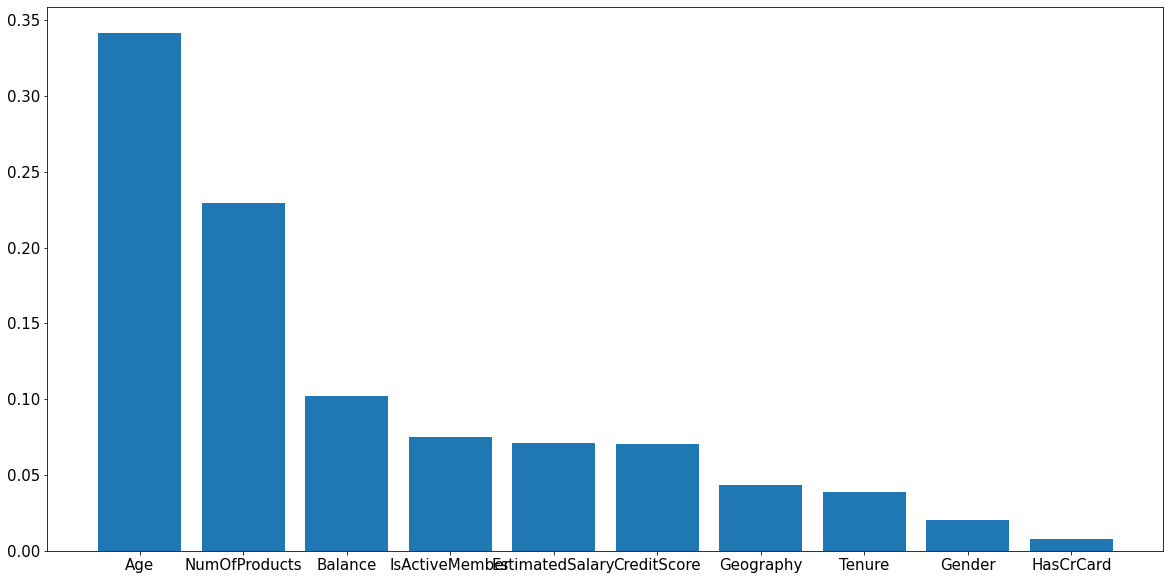

In [92]:
fig = plt.figure(figsize=[20,10])
plt.bar(x,y)

In [93]:
cb= estimators[4][1].fit(df_1.drop('target',1),df_1['target'])

In [94]:
imported_line=cb.feature_importances_
imported_line = list(zip(df_1.drop('target',1).columns.to_list(),imported_line))
imported_line.sort(key = lambda x: x[1],reverse=True)  
x = [i[0] for i in imported_line]
y = [i[1] for i in imported_line]
imported_line

[('NumOfProducts', 33.677875431468095),
 ('Age', 25.460526773403604),
 ('Balance', 12.16332062168602),
 ('Geography', 11.232633597742891),
 ('IsActiveMember', 8.862338936823587),
 ('Gender', 3.054910427339537),
 ('EstimatedSalary', 1.937135598515935),
 ('CreditScore', 1.72911949631877),
 ('Tenure', 1.4908024860089344),
 ('HasCrCard', 0.3913366306926267)]

<BarContainer object of 10 artists>

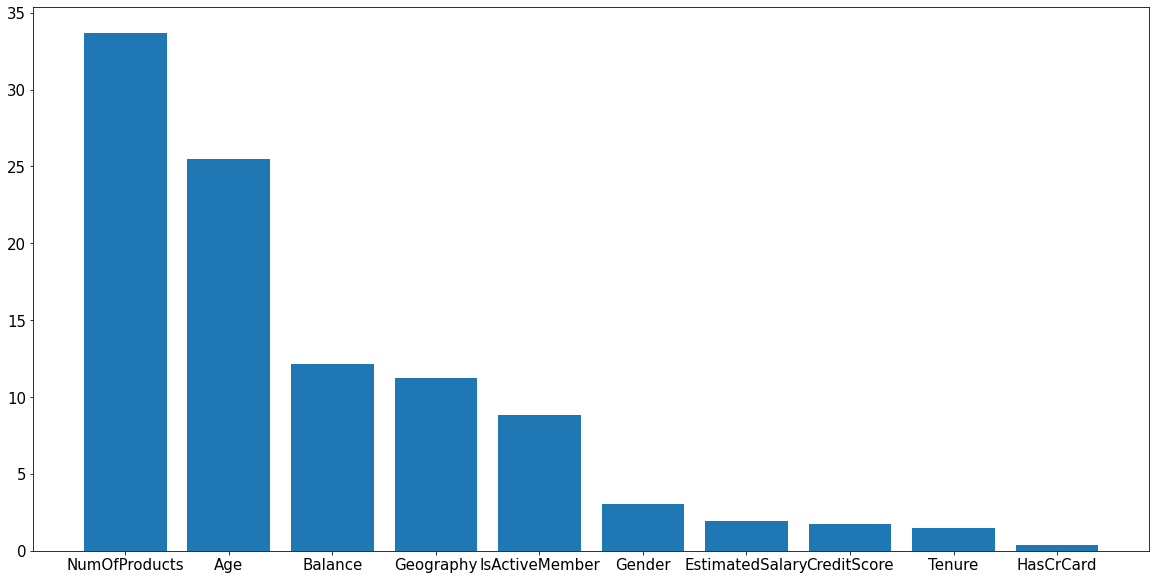

In [95]:
fig = plt.figure(figsize=[20,10])
plt.bar(x,y)

Попоробуем посмотреть на результаты без полей HasCrCard и Tenure

In [96]:
pipeline_lr = make_pipeline_for_lr(for_ohe_columns,df_work.drop(['target','HasCrCard'],1).columns.to_list())

In [97]:
estimators_base_1= estimators_base.copy()
estimators_base_1[0]=('lr',pipeline_lr)

In [98]:
res_base_1 = test_estimators(df_1.drop(['target','HasCrCard'],1),df_1['target'],\
                             estimators_base_1,cv_strategy,roc_auc_score,print_is=False)
res_base_1

{'lr': 0.7650294862141923,
 'rf': 0.8489820463827826,
 'lgb': 0.8595180113523326,
 'xgb': 0.8401844848082667,
 'cb': 0.8640040575486859}

In [99]:
res_base

{'lr': 0.7649068645973145,
 'rf': 0.8490464705103027,
 'lgb': 0.8593407987642404,
 'xgb': 0.8417467544881576,
 'cb': 0.8637137482506074}

ИЗМЕНЕНИЯ НА УРОВНЕ ПОГРЕШНОСТЕЙ

In [100]:
pipeline_lr = make_pipeline_for_lr(for_ohe_columns,df_work.drop(['target','Tenure'],1).columns.to_list())

In [101]:
estimators_base_1= estimators_base.copy()
estimators_base_1[0]=('lr',pipeline_lr)

In [102]:
res_base_1 = test_estimators(df_1.drop(['target','Tenure'],1),df_1['target'],\
                             estimators_base_1,cv_strategy,roc_auc_score,print_is=False)
res_base_1

{'lr': 0.7650844779096448,
 'rf': 0.8515833323623476,
 'lgb': 0.8587003797817729,
 'xgb': 0.8396000747443177,
 'cb': 0.8637429702950521}

In [103]:
pipeline_lr = make_pipeline_for_lr(for_ohe_columns,df_work.drop(['target','Tenure','HasCrCard'],1).columns.to_list())

In [104]:
estimators_base_1= estimators_base.copy()
estimators_base_1[0]=('lr',pipeline_lr)

In [105]:
res_base_1 = test_estimators(df_1.drop(['target','Tenure'],1),df_1['target'],\
                             estimators_base_1,cv_strategy,roc_auc_score,print_is=False)
res_base_1

{'lr': 0.765235766722022,
 'rf': 0.8489296748073486,
 'lgb': 0.8587003797817729,
 'xgb': 0.8396000747443177,
 'cb': 0.8637429702950521}

Генедер Страна

In [107]:
new=pd.DataFrame()

In [108]:
new['geo_gender']=df['Geography']+df['Gender']
new['geo_gender'] = new['geo_gender'].map(new['geo_gender'].value_counts()/new['geo_gender'].count())

In [109]:
def age(x):
    x=int(x)
    if x<25:
        return 1
    if x<38:
        return 2
    if x< 45:
        return 3
    if x < 56:
        return 4
    if x <76:
        return 5
    return 6

In [110]:
new['group_age'] = df['Age'].apply(age)

In [111]:
new['group_age']=new['group_age'].map(new['group_age'].value_counts())/new['group_age'].count()

In [112]:
new['group_age'].value_counts()

0.4630    4630
0.2573    2573
0.1540    1540
0.0755     755
0.0457     457
0.0045      45
Name: group_age, dtype: int64

In [113]:
new['geo_age']=df['Geography']+new['group_age'].astype('str')
new['geo_age'] = new['geo_age'].map(new['geo_age'].value_counts()/new['geo_age'].count())

In [114]:
new['geo_gender_age']=new['geo_gender'].astype('str')+new['group_age'].astype('str')
new['geo_gender_age'] = new['geo_gender_age'].map(new['geo_gender_age'].value_counts()/new['geo_gender_age'].count())

In [115]:
new['gender_age']=df['Gender']+new['group_age'].astype('str')
new['gender_age'] = new['gender_age'].map(new['gender_age'].value_counts()/new['gender_age'].count())

In [116]:
new['age'] = df['Age']
new['geo_gender_age_median'] = new['geo_gender_age'].map(
    new.groupby('geo_gender_age')['age'].median())
new.drop('age',1,inplace=True)

In [117]:
new['CreditScore'] = df['CreditScore']
new['geo_gender_age_CreditScore'] = new['geo_gender_age'].map(
    new.groupby('geo_gender_age')['CreditScore'].median())
new.drop('CreditScore',1,inplace=True)

In [118]:
new['Balance'] = df['Balance']
new['geo_gender_age_Balance'] = new['geo_gender_age'].map(
    new.groupby('geo_gender_age')['Balance'].median())
new.drop('Balance',1,inplace=True)

In [119]:
# new['Balance'] = df['Balance']
# new['geo_gender_age_Balance'] = new['geo_gender_age'].map(
#     new.groupby('geo_gender_age')['Balance'].median())
# new.drop('Balance',1,inplace=True)

In [120]:
new['EstimatedSalary'] = df['EstimatedSalary']
new['geo_gender_age_EstimatedSalary'] = new['geo_gender_age'].map(
    new.groupby('geo_gender_age')['EstimatedSalary'].median())
new.drop('EstimatedSalary',1,inplace=True)

In [121]:
new['NumOfProducts'] = df['NumOfProducts']
new['geo_gender_age_NumOfProducts']=new['geo_gender_age'].astype('str')+df['NumOfProducts'].astype('str')
new['geo_gender_age_NumOfProducts'] = new['geo_gender_age_NumOfProducts'].map(new['geo_gender_age_NumOfProducts'].value_counts()/new['geo_gender_age_NumOfProducts'].count())
new.drop('NumOfProducts',1,inplace=True)

In [122]:
num_coumns  = ['CreditScore','Balance','EstimatedSalary']

In [123]:
for i in num_coumns:
    new[i+'_log'] = np.log(df[i] + 1.1)

In [124]:
for i in num_coumns:
    new[i+'_sqrt'] = np.sqrt(df[i])

In [125]:
for col1 in num_coumns:
    for col2 in num_coumns:
        new[col1+'_'+col2+'_*'] = np.log(df[col1] +1.1)*np.log(df[col2]+1.1)
        if col1!=col2:
            new[col1+'_'+col2+'_/'] = np.log(df[col1] +1.1)/np.log(df[col2]+1.1)
        

In [126]:
# new.drop(['CreditScorelog','Balancelog','EstimatedSalarylog'],1,inplace=True)

In [127]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   geo_gender                         10000 non-null  float64
 1   group_age                          10000 non-null  float64
 2   geo_age                            10000 non-null  float64
 3   geo_gender_age                     10000 non-null  float64
 4   gender_age                         10000 non-null  float64
 5   geo_gender_age_median              10000 non-null  float64
 6   geo_gender_age_CreditScore         10000 non-null  float64
 7   geo_gender_age_Balance             10000 non-null  float64
 8   geo_gender_age_EstimatedSalary     10000 non-null  float64
 9   geo_gender_age_NumOfProducts       10000 non-null  float64
 10  CreditScore_log                    10000 non-null  float64
 11  Balance_log                        10000 non-null  floa

In [128]:
new_cat=['geo_gender','group_age','geo_age','geo_gender_age']

In [129]:
res_base

{'lr': 0.7649068645973145,
 'rf': 0.8490464705103027,
 'lgb': 0.8593407987642404,
 'xgb': 0.8417467544881576,
 'cb': 0.8637137482506074}

#### Проверим дает ли прирост скора каждое поле в отельности

In [130]:
%%time
cat=[]
res_new_featch = {}
estimators_base_1= estimators_base.copy()
estimators_base_1[0]=('lr',pipeline_lr)
for i in new.columns.to_list():
    cat=[]
    work_df = pd.concat([df_1,new[i]],axis=1)
    if i in new_cat:
        cat.append(i)
    pipeline_lr = make_pipeline_for_lr(for_ohe_columns+ cat,work_df.drop('target',1).columns.to_list(),estimator=LogisticRegression(max_iter=1000))
    estimators_base_1[0]=('lr',pipeline_lr)
    res_base_n = test_estimators(work_df.drop(['target'],1),work_df['target'],\
                             estimators_base_1,cv_strategy,roc_auc_score,print_is=False)
    d={}
    for j,k in res_base_n.items():
        d[j]=k-res_base[j]
    res_new_featch[i]=d
  
    
        
    
    

Wall time: 12min 47s


In [131]:
res_new_featch

{'geo_gender': {'lr': -0.00024345538715497828,
  'rf': 0.0017096437247107188,
  'lgb': 0.001783746883829651,
  'xgb': 0.0009613374473533831,
  'cb': -0.00011405228316940796},
 'group_age': {'lr': 0.019967657238488257,
  'rf': -0.001100542882702893,
  'lgb': 0.0004951718586041487,
  'xgb': -0.0004927366882334638,
  'cb': -0.0003999844395694563},
 'geo_age': {'lr': 0.01844965217444361,
  'rf': -0.002171832896020076,
  'lgb': -0.00020948630173511784,
  'xgb': -0.000283743585560825,
  'cb': -0.0011054440483848627},
 'geo_gender_age': {'lr': 0.017658314278895748,
  'rf': -0.002766970039574823,
  'lgb': -0.00039714854496097907,
  'xgb': 0.0003997378400384388,
  'cb': 7.250026216631955e-05},
 'gender_age': {'lr': 0.005613160178540411,
  'rf': -0.0036012470784891892,
  'lgb': 0.0007063227071746336,
  'xgb': 6.436247763730307e-05,
  'cb': -0.0013001343782494956},
 'geo_gender_age_median': {'lr': 0.00035158928157597025,
  'rf': -0.00018960421453417808,
  'lgb': -0.0004497050700431604,
  'xgb': -

Как видно по одному ни один признак не вносит какого то значимого эффекта

Посмотрим если будут все признаки

In [132]:
 work_df = pd.concat([df_1,new],axis=1)

In [133]:
pipeline_lr = make_pipeline_for_lr(for_ohe_columns+ new_cat,work_df.drop('target',1).columns.to_list(),\
                                   estimator=LogisticRegression(max_iter=1000))
estimators_base_1[0]=('lr',pipeline_lr)
res_base_all = test_estimators(work_df.drop(['target'],1),work_df['target'],\
                             estimators_base_1,cv_strategy,roc_auc_score)


#########################################   lr   ###################################################

Fold: 1, train-observations = 8000, valid-observations = 2000
train-score = 0.8258, valid-score = 0.8016
Fold: 2, train-observations = 8000, valid-observations = 2000
train-score = 0.8173, valid-score = 0.8393
Fold: 3, train-observations = 8000, valid-observations = 2000
train-score = 0.8229, valid-score = 0.8114
Fold: 4, train-observations = 8000, valid-observations = 2000
train-score = 0.8272, valid-score = 0.794
Fold: 5, train-observations = 8000, valid-observations = 2000
train-score = 0.8196, valid-score = 0.8263
CV-results train: 0.8226 +/- 0.004
CV-results valid: 0.8145 +/- 0.016
OOF-score = 0.8139

#########################################   rf   ###################################################

Fold: 1, train-observations = 8000, valid-observations = 2000
train-score = 1.0, valid-score = 0.8313
Fold: 2, train-observations = 8000, valid-observations = 2000
train-score = 1.0

In [134]:
res_base

{'lr': 0.7649068645973145,
 'rf': 0.8490464705103027,
 'lgb': 0.8593407987642404,
 'xgb': 0.8417467544881576,
 'cb': 0.8637137482506074}

In [135]:
res_base_all

{'lr': 0.813868831613271,
 'rf': 0.8418828466044261,
 'lgb': 0.852807699034643,
 'xgb': 0.8376033583403752,
 'cb': 0.862079964706675}

In [136]:
res_base_tune

{'lr': 0.7656366142599508,
 'rf': 0.86010833980503,
 'lgb': 0.8666319454526769,
 'xgb': 0.8689753807974547,
 'cb': 0.869539107325726}

Как видно результаты улучшились только на линейной моделе

Попробуем тюнинг

#### ЛогРег

In [137]:
%%time
pipeline_lr = make_pipeline_for_lr(for_ohe_columns+ new_cat,work_df.drop('target',1).columns.to_list(),\
                                   estimator=LogisticRegression(max_iter=1000))
clf_lr = GridSearchCV(pipeline_lr, param_grid_lr,\
                   scoring='roc_auc',n_jobs = -1,cv =cv_strategy)
a=clf_lr.fit(work_df.drop('target',1), work_df['target'])
print(a.best_score_,a.best_params_)

0.8147482595209435 {'classifier__C': 5, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Wall time: 2min 16s


#### Случайный лес

In [138]:
%%time
z=rsp_rf.fit(work_df.drop('target',1), work_df['target'])
print(z.best_score_,z.best_params_)

0.8536095457136901 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 10}
Wall time: 4min 6s


#### lgm

In [139]:
%%time
z=rsp_rf.fit(work_df.drop('target',1), work_df['target'])
print(z.best_score_,z.best_params_)

0.8535390159851559 {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 11}
Wall time: 3min 58s


#### xgb

In [140]:
%%time
x=rsp_xgb.fit(work_df.drop('target',1), work_df['target'])
print(x.best_score_,x.best_params_)

0.8633684580498597 {'subsample': 1, 'reg_lambda': 7, 'reg_alpha': 5, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 3, 'colsample_bytree': 0.5}
Wall time: 6min 58s


#### CB

In [141]:
%%time
t=rsp_cb.fit(work_df.drop('target',1), work_df['target'])
print(t.best_score_,t.best_params_)

C:\Users\lqw\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.8678192546462613 {'n_estimators': 600, 'max_depth': 4, 'max_bin': 40, 'learning_rate': 0.03, 'l2_leaf_reg': 5}
Wall time: 37min 24s


Удалим искуственные данные

In [142]:
new_1 = new.drop(['EstimatedSalary_EstimatedSalary_*',
          'EstimatedSalary_Balance_/','EstimatedSalary_Balance_*','EstimatedSalary_CreditScore_/',
          'EstimatedSalary_CreditScore_*','Balance_EstimatedSalary_/','Balance_EstimatedSalary_*',
          'Balance_Balance_*','Balance_CreditScore_/','CreditScore_EstimatedSalary_/',
          'CreditScore_EstimatedSalary_*','CreditScore_Balance_/','CreditScore_Balance_*','CreditScore_CreditScore_*'     
         ],1)

In [143]:
 work_df_1 = pd.concat([df_1,new_1],axis=1)

#### ЛогРег

In [144]:
%%time
pipeline_lr = make_pipeline_for_lr(for_ohe_columns+ new_cat,work_df_1.drop('target',1).columns.to_list(),\
                                   estimator=LogisticRegression(max_iter=1000))
clf_lr = GridSearchCV(pipeline_lr, param_grid_lr,\
                   scoring='roc_auc',n_jobs = -1,cv =cv_strategy)
a=clf_lr.fit(work_df_1.drop('target',1), work_df_1['target'])
print(a.best_score_,a.best_params_)

0.8147172733232917 {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Wall time: 39.1 s


#### Случайный лес

In [145]:
%%time
z=rsp_rf.fit(work_df_1.drop('target',1), work_df_1['target'])
print(z.best_score_,z.best_params_)

C:\Users\lqw\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.8586419141726296 {'n_estimators': 270, 'min_samples_split': 8, 'min_samples_leaf': 7}
Wall time: 2min 37s


#### lgm

In [146]:
%%time
z=rsp_rf.fit(work_df_1.drop('target',1), work_df_1['target'])
print(z.best_score_,z.best_params_)

0.858464286856376 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 9}
Wall time: 2min 25s


#### xgb

In [147]:
%%time
x=rsp_xgb.fit(work_df_1.drop('target',1), work_df_1['target'])
print(x.best_score_,x.best_params_)

0.8646372569261608 {'subsample': 1, 'reg_lambda': 30, 'reg_alpha': 2, 'n_estimators': 500, 'min_child_weight': 0.01, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 4, 'colsample_bytree': 0.5}
Wall time: 4min 4s


#### CB

In [148]:
%%time
t=rsp_cb.fit(work_df_1.drop('target',1), work_df_1['target'])
print(t.best_score_,t.best_params_)

C:\Users\lqw\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.8685956894607318 {'n_estimators': 300, 'max_depth': 4, 'max_bin': 30, 'learning_rate': 0.05, 'l2_leaf_reg': 10}
Wall time: 32min 32s


#### Получим лучшие результаты по всем моделям

In [149]:
train_ind,test_ind = train_test_split(df.index, test_size = 0.2, random_state=49)

In [150]:
# lr
pipeline_lr = make_pipeline_for_lr(for_ohe_columns+ new_cat,work_df_1.drop('target',1).columns.to_list(),\
                                   estimator=LogisticRegression(max_iter=1000,C= 5, penalty= 'l2',
                                                               solver= 'lbfgs'))

pipeline_lr.fit(work_df_1.drop('target',1).loc[train_ind],work_df_1['target'].loc[train_ind])
preds_lr = pipeline_lr.predict_proba(work_df_1.drop('target',1).loc[test_ind])[:,1]

In [151]:
model_rf = RandomForestClassifier(**{'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 300})
model_rf.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
prds_rf = model_rf.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]

In [152]:
model_lgm = LGBMClassifier(**{'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 20,
                              'n_estimators': 400, 'min_child_samples': 5, 'max_depth': 12, 'learning_rate': 0.01})
model_lgm.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
prds_lgm = model_lgm.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]

In [153]:
model_xgb =  XGBClassifier( reg_alpha= 0.0003505581594368275,
    reg_lambda= 0.01039632647049951,
    gamma= 12,
#     min_child_samples=19.477433204858446,
    n_estimators=1000,
    learning_rate=0.133172792297014,
    max_depth=6,
    subsample=0.9209157538505218,
    min_child_weight=1.8132888583475881,
    colsample_bytree=0.31114111556444424)
model_xgb.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
prds_xgb = model_xgb.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]

In [154]:
model_cb = CatBoostClassifier(verbose = False,
    n_estimators= 307,
    learning_rate= 0.029591843327651066,
    max_depth= 5,
    max_bin= 46,
    l2_leaf_reg= 15.864663358593761)
model_cb.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
prds_cb = model_cb.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]

In [190]:
predict = pd.DataFrame()

In [191]:
predict['lr'] = preds_lr
predict['rf'] = prds_rf
predict['lgm'] = prds_lgm
predict['xgb'] = prds_xgb
predict['cb'] = prds_cb


In [192]:
predict_columns = predict.columns.to_list()
for ind,i in enumerate(predict_columns):
    my_list = predict_columns[ind:]
    for _ in range(len(my_list)-1):
        predict['_'.join(my_list)+'_mean'] = predict[my_list].mean(axis = 1)
        predict['_'.join(my_list)+'_max'] = predict[my_list].max(axis = 1)
        predict['_'.join(my_list)+'_min'] = predict[my_list].min(axis = 1) 
        my_list.pop()

In [193]:
predict

,lr,rf,lgm,xgb,cb,lr_rf_lgm_xgb_cb_mean,lr_rf_lgm_xgb_cb_max,lr_rf_lgm_xgb_cb_min,lr_rf_lgm_xgb_mean,lr_rf_lgm_xgb_max,...,rf_lgm_min,lgm_xgb_cb_mean,lgm_xgb_cb_max,lgm_xgb_cb_min,lgm_xgb_mean,lgm_xgb_max,lgm_xgb_min,xgb_cb_mean,xgb_cb_max,xgb_cb_min
0,0.027965,0.032390,0.049126,0.054232,0.046435,0.042030,0.054232,0.027965,0.040928,0.054232,...,0.032390,0.049931,0.054232,0.046435,0.051679,0.054232,0.049126,0.050334,0.054232,0.046435
1,0.013686,0.025250,0.023557,0.011789,0.010654,0.016987,0.025250,0.010654,0.018570,0.025250,...,0.023557,0.015333,0.023557,0.010654,0.017673,0.023557,0.011789,0.011222,0.011789,0.010654
2,0.417831,0.709373,0.751776,0.726319,0.731309,0.667322,0.751776,0.417831,0.651325,0.751776,...,0.709373,0.736468,0.751776,0.726319,0.739048,0.751776,0.726319,0.728814,0.731309,0.726319
3,0.107091,0.129243,0.102334,0.102440,0.110515,0.110325,0.129243,0.102334,0.110277,0.129243,...,0.102334,0.105096,0.110515,0.102334,0.102387,0.102440,0.102334,0.106477,0.110515,0.102440
4,0.260882,0.314468,0.291476,0.291703,0.282981,0.288302,0.314468,0.260882,0.289633,0.314468,...,0.291476,0.288720,0.291703,0.282981,0.291590,0.291703,0.291476,0.287342,0.291703,0.282981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.108327,0.148417,0.123445,0.129572,0.123947,0.126742,0.148417,0.108327,0.127440,0.148417,...,0.123445,0.125655,0.129572,0.123445,0.126509,0.129572,0.123445,0.126760,0.129572,0.123947
1996,0.225004,0.109282,0.096340,0.130045,0.124680,0.137070,0.225004,0.096340,0.140168,0.225004,...,0.096340,0.117022,0.130045,0.096340,0.113193,0.130045,0.096340,0.127363,0.130045,0.124680
1997,0.026845,0.021872,0.043388,0.032054,0.025171,0.029866,0.043388,0.021872,0.031040,0.043388,...,0.021872,0.033538,0.043388,0.025171,0.037721,0.043388,0.032054,0.028613,0.032054,0.025171
1998,0.044350,0.069298,0.061063,0.056299,0.065521,0.059306,0.069298,0.044350,0.057752,0.069298,...,0.061063,0.060961,0.065521,0.056299,0.058681,0.061063,0.056299,0.060910,0.065521,0.056299


In [194]:
predict_columns = predict.columns.to_list()
score=  pd.DataFrame(columns = ['roc_auc','profit','best_split'], index = predict_columns)

for i in  predict_columns:
    score.loc[i,'roc_auc'] = roc_auc_score(df_1['target'].loc[test_ind],predict[i])
    

In [195]:
score.sort_values(by = 'roc_auc',ascending=False)

,roc_auc,profit,best_split
xgb_cb_min,0.874908,NaN,NaN
lgm_xgb_cb_mean,0.874427,NaN,NaN
lgm_xgb_mean,0.874178,NaN,NaN
lgm_xgb_max,0.874122,NaN,NaN
lgm_xgb_cb_min,0.874122,NaN,NaN
xgb_cb_mean,0.873991,NaN,NaN
lgm_xgb_cb_max,0.873796,NaN,NaN
cb,0.873461,NaN,NaN
rf_lgm_xgb_cb_mean,0.873353,NaN,NaN
lgm,0.872843,NaN,NaN


Теперь посчитаем с точки зрения прибыли

In [196]:
for col in predict_columns:
    res = []
    for th in np.arange(0.05,0.95,0.01):
        cnf_matrix = confusion_matrix(df_1['target'].loc[test_ind], predict[col]>th)
        TP = cnf_matrix[1,1]
        FP = cnf_matrix[0,1]
        profit = TP*2 -(TP+FP)
        res.append((th,profit))
    res.sort(key = lambda x: x[1])    
    best_split = res[-1][0]
    max_profit = res[-1][1]
    score.loc[col,'profit'] =  max_profit
    score.loc[col,'best_split'] = best_split
    
    
    

In [197]:
score.sort_values(by = 'profit',ascending=False)

,roc_auc,profit,best_split
xgb,0.872593,173,0.53
rf_lgm_xgb_cb_mean,0.873353,172,0.46
lgm_xgb_max,0.874122,172,0.48
lgm_xgb_mean,0.874178,172,0.49
rf_lgm_xgb_cb_max,0.869299,171,0.53
xgb_cb_max,0.872486,171,0.53
xgb_cb_mean,0.873991,171,0.46
lgm_xgb_cb_max,0.873796,171,0.52
lgm_xgb_cb_mean,0.874427,171,0.48
rf_lgm_xgb_max,0.869157,171,0.53


### При разбиение на test используя random_state=49 , наиболее выгодно использовать модель предсказаний на xgb, при пороге 0,53. При изменении этого параметра ситуация меняется

In [258]:
train_ind,test_ind = train_test_split(df.index, test_size = 0.2, random_state=40)

In [259]:
%%time
pipeline_lr.fit(work_df_1.drop('target',1).loc[train_ind],work_df_1['target'].loc[train_ind])
preds_lr = pipeline_lr.predict_proba(work_df_1.drop('target',1).loc[test_ind])[:,1]
model_rf.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
prds_rf = model_rf.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]
model_lgm.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
prds_lgm = model_lgm.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]
model_xgb.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
prds_xgb = model_xgb.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]
model_cb.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
prds_cb = model_cb.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]
predict = pd.DataFrame()
predict['lr'] = preds_lr
predict['rf'] = prds_rf
predict['lgm'] = prds_lgm
predict['xgb'] = prds_xgb
predict['cb'] = prds_cb
predict_columns = predict.columns.to_list()
predict_columns = predict.columns.to_list()
for ind,i in enumerate(predict_columns):
    my_list = predict_columns[ind:]
    for _ in range(len(my_list)-1):
        predict['_'.join(my_list)+'_mean'] = predict[my_list].mean(axis = 1)
        predict['_'.join(my_list)+'_max'] = predict[my_list].max(axis = 1)
        predict['_'.join(my_list)+'_min'] = predict[my_list].min(axis = 1) 
        my_list.pop()
predict_columns = predict.columns.to_list()
score=  pd.DataFrame(columns = ['roc_auc','profit','best_split'], index = predict_columns)

for i in  predict_columns:
    score.loc[i,'roc_auc'] = roc_auc_score(df_1['target'].loc[test_ind],predict[i])
for col in predict_columns:
    res = []
    for th in np.arange(0.05,0.95,0.01):
        cnf_matrix = confusion_matrix(df_1['target'].loc[test_ind], predict[col]>th)
        TP = cnf_matrix[1,1]
        FP = cnf_matrix[0,1]
        profit = TP*2 -(TP+FP)
        res.append((th,profit))
    res.sort(key = lambda x: x[1])    
    best_split = res[-1][0]
    max_profit = res[-1][1]
    score.loc[col,'profit'] =  max_profit
    score.loc[col,'best_split'] = best_split    
    


Wall time: 21 s


In [261]:
score.sort_values(by = 'profit',ascending=False)

,roc_auc,profit,best_split
rf_lgm_xgb_cb_min,0.881133,151,0.45
rf_lgm_xgb_min,0.88037,151,0.46
rf_lgm_min,0.87819,150,0.46
xgb_cb_min,0.881696,149,0.48
lgm_xgb_max,0.880273,148,0.56
rf_lgm_xgb_max,0.875313,148,0.56
rf_lgm_xgb_cb_mean,0.879867,148,0.54
rf_lgm_xgb_cb_max,0.875289,147,0.56
lgm_xgb_cb_max,0.880411,147,0.56
rf_lgm_xgb_mean,0.878871,146,0.53


#### Сделаем выборку из 50 разных вариантов и найдем среднее количесвто прибыли

In [271]:
%%time
res_profit=[]
for k in range(50):
    train_ind,test_ind = train_test_split(df.index, test_size = 0.2, random_state=k)
    pipeline_lr.fit(work_df_1.drop('target',1).loc[train_ind],work_df_1['target'].loc[train_ind])
    preds_lr = pipeline_lr.predict_proba(work_df_1.drop('target',1).loc[test_ind])[:,1]
    model_rf.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
    prds_rf = model_rf.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]
    model_lgm.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
    prds_lgm = model_lgm.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]
    model_xgb.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
    prds_xgb = model_xgb.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]
    model_cb.fit(df_1.drop('target',1).loc[train_ind],df_1['target'].loc[train_ind])
    prds_cb = model_cb.predict_proba(df_1.drop('target',1).loc[test_ind])[:,1]
    predict = pd.DataFrame()
    predict['lr'] = preds_lr
    predict['rf'] = prds_rf
    predict['lgm'] = prds_lgm
    predict['xgb'] = prds_xgb
    predict['cb'] = prds_cb
    predict_columns = predict.columns.to_list()
    predict_columns = predict.columns.to_list()
    for ind,i in enumerate(predict_columns):
        my_list = predict_columns[ind:]
        for _ in range(len(my_list)-1):
            predict['_'.join(my_list)+'_mean'] = predict[my_list].mean(axis = 1)
            predict['_'.join(my_list)+'_max'] = predict[my_list].max(axis = 1)
            predict['_'.join(my_list)+'_min'] = predict[my_list].min(axis = 1) 
            my_list.pop()
    predict_columns = predict.columns.to_list()
    score=  pd.DataFrame(columns = ['roc_auc','profit','best_split'], index = predict_columns)

    for i in  predict_columns:
        score.loc[i,'roc_auc'] = roc_auc_score(df_1['target'].loc[test_ind],predict[i])
    for col in predict_columns:
        res = []
        for th in np.arange(0.05,0.95,0.01):
            cnf_matrix = confusion_matrix(df_1['target'].loc[test_ind], predict[col]>th)
            TP = cnf_matrix[1,1]
            FP = cnf_matrix[0,1]
            profit = TP*2 -(TP+FP)
            res.append((th,profit))
        res.sort(key = lambda x: x[1])    
        best_split = res[-1][0]
        max_profit = res[-1][1]
        score.loc[col,'profit'] =  max_profit
        score.loc[col,'best_split'] = best_split    

    my_profit = score.sort_values(by = ['profit'],ascending=False).iloc[0,1]
    my_split = score.sort_values(by = ['profit'],ascending=False).iloc[0,2]
    my_ansamle = score.sort_values(by = ['profit'],ascending=False).index[0]
    res_profit.append((k,my_ansamle,my_profit,my_split))


Wall time: 17min 21s


In [274]:
res_profit.sort(key=lambda x:x[2],reverse = True)
res_profit

[(30, 'lgm_xgb_max', 187, 0.4800000000000001),
 (34, 'lgm_xgb_max', 178, 0.5000000000000001),
 (49, 'xgb', 173, 0.5300000000000001),
 (12, 'lr_rf_lgm_xgb_cb_max', 172, 0.5900000000000002),
 (8, 'lgm_xgb_cb_max', 171, 0.49000000000000005),
 (18, 'xgb_cb_mean', 167, 0.4700000000000001),
 (48, 'rf_lgm_xgb_cb_max', 163, 0.44000000000000006),
 (4, 'lgm_xgb_cb_max', 161, 0.4800000000000001),
 (1, 'rf_lgm_mean', 160, 0.4000000000000001),
 (29, 'lgm_xgb_max', 159, 0.5000000000000001),
 (45, 'lgm_xgb_max', 159, 0.4800000000000001),
 (9, 'lgm_xgb_mean', 157, 0.45000000000000007),
 (13, 'rf_lgm_xgb_cb_max', 153, 0.4700000000000001),
 (16, 'lgm_xgb_mean', 153, 0.4600000000000001),
 (44, 'rf_lgm_xgb_cb_max', 152, 0.5100000000000001),
 (0, 'xgb_cb_max', 151, 0.6100000000000001),
 (10, 'rf_lgm_xgb_cb_mean', 151, 0.44000000000000006),
 (24, 'lgm_xgb_cb_max', 151, 0.5000000000000001),
 (27, 'xgb', 151, 0.6200000000000001),
 (40, 'rf_lgm_xgb_min', 151, 0.45000000000000007),
 (19, 'lgm_xgb_mean', 150, 0.

Матиматическое ожидание полученной прибыли

In [275]:
sum(i[2] for i in res_profit)/len(res_profit)

145.5

самый лучший результат

In [276]:
res_profit[0]

(30, 'lgm_xgb_max', 187, 0.4800000000000001)

самый худший результат

In [277]:
res_profit[-1]

(2, 'rf_lgm_xgb_cb_max', 117, 0.5800000000000002)